# Часть 4. Прогнозирование большого количества рядов.

In [117]:
import numpy as np
import pandas as pd
import datetime
import os
import multiprocessing
import warnings

from joblib import dump, load
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

## 4.1 Чтение данных, составление таблицы

Возьмем данные декабря 2015-го по апрель 2016-го года. Отдельно возьмем май 16-го и июнь 16-го.

In [118]:
data = pd.read_csv('all_count.csv', sep=',', header=0, 
               date_parser=lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [119]:
dates = [datetime.datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in data.columns[5:]]

In [120]:
# Получение списка имён колонок по датам.
def get_dates_names(dates_list, min_date, max_date):
    res = list(filter(lambda x: x>= datetime.datetime.strptime(min_date, '%Y-%m-%d %H:%M:%S') and 
                      x < datetime.datetime.strptime(max_date, '%Y-%m-%d %H:%M:%S'), 
                      dates_list))
    return [i.strftime('%Y-%m-%d %H:%M:%S') for i in res]
    return res

In [121]:
dec_apr_data = data[list(data.columns[:5]) + 
                    get_dates_names(dates, '2015-12-01 00:00:00', '2016-05-01 00:00:00')]
dec_apr_data.columns = list(dec_apr_data.columns[:5]) + [datetime.datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in dec_apr_data.columns[5:]]
may_data = data[list(data.columns[:5]) + 
                get_dates_names(dates, '2016-05-01 00:00:00', '2016-06-01 00:00:00')]
may_data.columns = list(may_data.columns[:5]) + [datetime.datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in may_data.columns[5:]]

Повернем таблицу, убрем лишние строки.

In [122]:
data_for_clustering = dec_apr_data.transpose()
data_for_clustering.columns = np.array(data.region)
data_for_clustering = data_for_clustering.iloc[5:, :]
data_for_clustering.head()

1075  1076  1077  1125  1126   1127   1128   1129   1130  \
2015-12-01 00:00:00  19.0  43.0  26.0  76.0  91.0  129.0  202.0  230.0  212.0   
2015-12-01 01:00:00  16.0  22.0  12.0  29.0  71.0   84.0   89.0  118.0  177.0   
2015-12-01 02:00:00   8.0  19.0   3.0   9.0  21.0   42.0   76.0   99.0  180.0   
2015-12-01 03:00:00   3.0  12.0   5.0   7.0  17.0   33.0   45.0   93.0  136.0   
2015-12-01 04:00:00   2.0  12.0   3.0   7.0  21.0   33.0   27.0   62.0   80.0   

                     1131  ...  1630  1684  1733  1734  1783  2068  2069  \
2015-12-01 00:00:00  56.0  ...   3.0   0.0   2.0  97.0  29.0  96.0  16.0   
2015-12-01 01:00:00  18.0  ...   7.0   0.0   0.0   2.0   0.0  17.0   4.0   
2015-12-01 02:00:00  14.0  ...   5.0   0.0   0.0   0.0   0.0   4.0   1.0   
2015-12-01 03:00:00  12.0  ...   7.0   0.0   0.0   0.0   0.0   0.0   0.0   
2015-12-01 04:00:00   3.0  ...   4.0   1.0   0.0   4.0   2.0   2.0   0.0   

                      2118  2119   2168  
2015-12-01 00:00:00  246.0  31.0  118.0  
2015-12-01 01:00:00  104.0   5.0   75.0  
2015-12-01 02:00:00   28.0   0.0    0.0  
2015-12-01 03:00:00   50.0   0.0    0.0  
2015-12-01 04:00:00   23.0   1.0   15.0  

[5 rows x 102 columns]

## 4.2 Стандартизация.

Стандартизируем столбцы.

In [123]:
from sklearn.preprocessing import StandardScaler

In [124]:
data_for_clustering[data_for_clustering.columns] = StandardScaler().fit_transform(data_for_clustering)
data_for_clustering.head()

1075      1076      1077      1125      1126  \
2015-12-01 00:00:00 -1.059249 -1.059793 -0.967507  0.263459 -0.896916   
2015-12-01 01:00:00 -1.137490 -1.313825 -1.209043 -0.897258 -1.100342   
2015-12-01 02:00:00 -1.346132 -1.350115 -1.364316 -1.391179 -1.608908   
2015-12-01 03:00:00 -1.476534 -1.434792 -1.329811 -1.440572 -1.649593   
2015-12-01 04:00:00 -1.502614 -1.434792 -1.364316 -1.440572 -1.608908   

                         1127      1128      1129      1130      1131  ...  \
2015-12-01 00:00:00 -0.967658 -0.534278 -0.547410 -0.756211 -0.984693  ...   
2015-12-01 01:00:00 -1.282486 -1.187228 -1.099971 -0.905581 -1.501337  ...   
2015-12-01 02:00:00 -1.576325 -1.262346 -1.193709 -0.892778 -1.555720  ...   
2015-12-01 03:00:00 -1.639290 -1.441474 -1.223310 -1.080558 -1.582912  ...   
2015-12-01 04:00:00 -1.639290 -1.545484 -1.376252 -1.319551 -1.705275  ...   

                         1630      1684      1733      1734      1783  \
2015-12-01 00:00:00 -0.407136 -0.872440 -0.612507 -0.694292 -1.055433   
2015-12-01 01:00:00  0.475093 -0.872440 -0.965776 -1.320248 -1.282767   
2015-12-01 02:00:00  0.033978 -0.872440 -0.965776 -1.333426 -1.282767   
2015-12-01 03:00:00  0.475093 -0.872440 -0.965776 -1.333426 -1.282767   
2015-12-01 04:00:00 -0.186579 -0.791252 -0.965776 -1.307070 -1.267089   

                         2068      2069      2118      2119      2168  
2015-12-01 00:00:00  0.172806  0.827983  1.526366  0.095599  1.402640  
2015-12-01 01:00:00 -1.198001 -0.666935 -0.364634 -0.938190  0.270499  
2015-12-01 02:00:00 -1.423577 -1.040665 -1.376718 -1.136996 -1.704166  
2015-12-01 03:00:00 -1.492985 -1.165242 -1.083747 -1.136996 -1.704166  
2015-12-01 04:00:00 -1.458281 -1.165242 -1.443303 -1.097235 -1.309233  

[5 rows x 102 columns]

Посмотрим на какой-нибудь график.

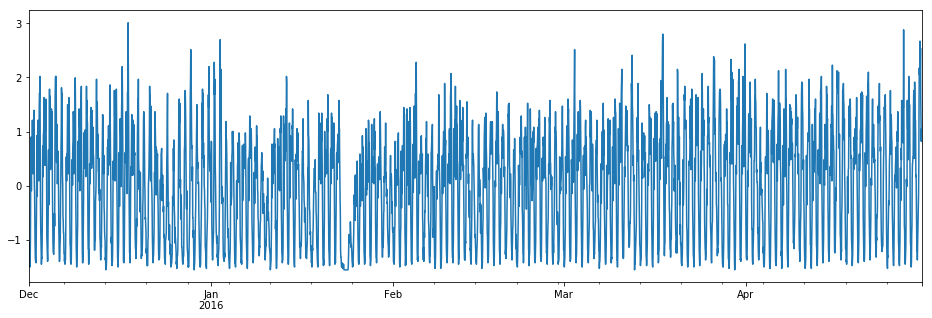

In [125]:
fig, ax = plt.subplots(figsize=(16,5))
data_for_clustering[1075].plot()
plt.show()

## 4.3 Кластеризация.

### 4.3.1 Понижение размерности.

Попробуем понизить размерность до двух, и напечатать результаты на плоскости. Применим методы случайных и главных компонент, Truncated SVD, MDS, TSNE.

In [126]:
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import MDS, TSNE
from sklearn.metrics import pairwise_distances
from sklearn.random_projection import SparseRandomProjection

In [127]:
random_state = 30
vals = np.array(data_for_clustering).T

In [128]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

obs = [SparseRandomProjection(2, random_state=random_state), PCA(2, random_state=random_state), 
       TruncatedSVD(2, random_state=random_state), TSNE(2, random_state=random_state), 
       MDS(2, random_state=random_state)]
titles = ['Random projection', 'PCA', 'TruncatedSVD', 'TSNE', 'MDS']
for i in range(len(obs)):
    points = obs[i].fit_transform(vals)
    ax = axs[i%2, i%3]
    ax.scatter([j[0] for j in points], [j[1] for j in points])
    ax.set_title(titles[i])
mds_model = MDS(n_components=2, dissimilarity='precomputed')
points = mds_model.fit_transform(pairwise_distances(vals, metric='cosine'))
ax = axs[-1, -1]
ax.scatter([j[0] for j in points], [j[1] for j in points])
ax.set_title('MDS cosine')
plt.show()

/home/artem/anaconda3/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


На TSNE визуально точки неплохо делятся 5 - 6 кластеров.

### 4.3.2. K-Means.

In [129]:
from sklearn.cluster import KMeans

Примем 5 кластеров.

In [130]:
km_model = KMeans(n_clusters=5, random_state=random_state)
km_preds = km_model.fit_predict(vals)

/home/artem/anaconda3/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


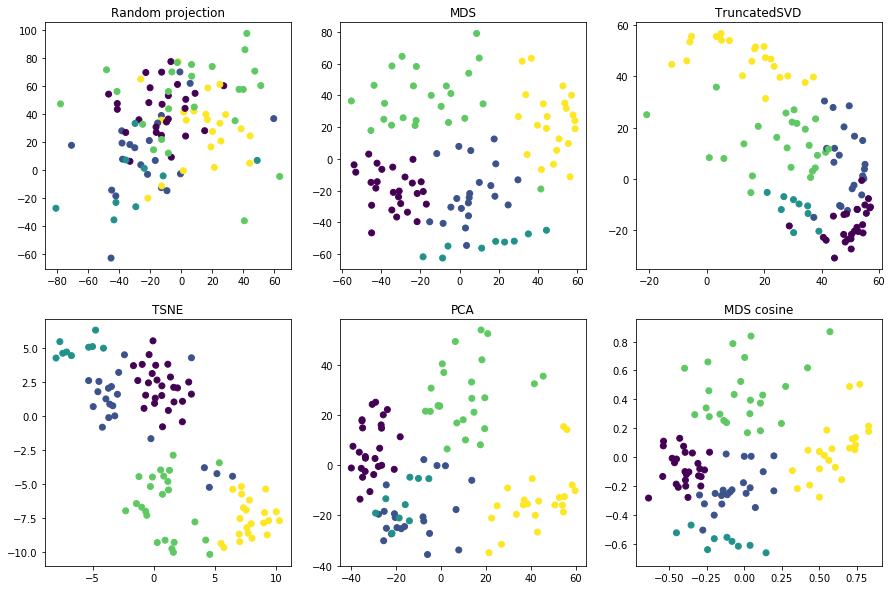

In [131]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
vals = np.array(data_for_clustering).T
random_state = 30
obs = [SparseRandomProjection(2, random_state=random_state), PCA(2, random_state=random_state), 
       TruncatedSVD(2, random_state=random_state), 
       TSNE(2, perplexity=23, learning_rate=200, random_state=random_state), 
       MDS(2, random_state=random_state)]
titles = ['Random projection', 'PCA', 'TruncatedSVD', 'TSNE', 'MDS']
for i in range(len(obs)):
    points = obs[i].fit_transform(vals)
    ax = axs[i%2, i%3]
    ax.scatter([j[0] for j in points], [j[1] for j in points], c=km_preds)
    ax.set_title(titles[i])
mds_model = MDS(n_components=2, dissimilarity='precomputed')
points = mds_model.fit_transform(pairwise_distances(vals, metric='cosine'))
ax = axs[-1, -1]
ax.scatter([j[0] for j in points], [j[1] for j in points], c=km_preds)
ax.set_title('MDS cosine')
plt.show()

In [132]:
from collections import Counter

In [133]:
Counter(km_preds)

Counter({1: 21, 0: 26, 4: 22, 3: 24, 2: 9})

Представим это дело на карте.

In [134]:
import folium
import os
from matplotlib import colors
from matplotlib import image as pltimg

In [135]:
color_names = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'white']
color_hex = [colors.to_hex(j) for j in color_names]

In [136]:
def plot_clusters(preds, filename):    
    fig, axs = plt.subplots(1, len(set(preds)))
    for i in set(preds):
        ax = axs[i]
        title = 'Кластер {}'.format(i)
        colr = colors.to_rgb(color_hex[i])
        ax.imshow([[colr for x in range(20)] for y in range(20)])
        ax.set_title(title)
        ax.axis('off')
    plt.show()
    
    
    # Карта.
    
    m = folium.Map(location=[40.75, -73.96], 
               #width='80%', height='80%', 
               zoom_start=11, 
               png_enabled=False)
               #tiles = 'Mapbox Bright')
    
    coord_data = np.array(data.iloc[:, :5])
    
    features = []
    for i in range(data.shape[0]):
        
        west = coord_data[i][1]
        east = coord_data[i][2]
        south = coord_data[i][3]
        north = coord_data[i][4]
        
        left_down = (south, west)
        left_up = (north, west)
        right_up = (north, east)
        right_down = (south, east)
        
        color = color_hex[preds[i]]
        
        
        folium.vector_layers.Rectangle([left_down, left_up, right_up, right_down], 
                                   popup=None, tooltip='Кластер {}'.format(preds[i]), 
                                   fill=True, fill_color=color, fill_opacity = 0.5,
                                   stroke=True, color='black', weight=1, opacity=0.1).add_to(m) #Color('Black').hex_l
    m.save('maps/{}.html'.format(filename))
    
    
    # Сохраняем в png.
    outdir = os.path.dirname(os.path.abspath('file'))
    url = "file://{}/maps/{}.html".format(os.getcwd(), filename)
    outfn = os.path.join(outdir, "maps/{}.png".format(filename))
    com = 'cutycapt --url={} --out={} --delay=1000 --plugins=on --javascript=on --js-can-access-clipboard=on --java=on'.format(url, outfn)
    os.system(com)
    
    return m

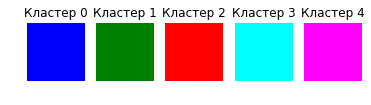

In [137]:
plot_clusters(km_preds, 'map_4_3_2')

Вряд ли у вас отобразилась динамическая карта, так что вот png.

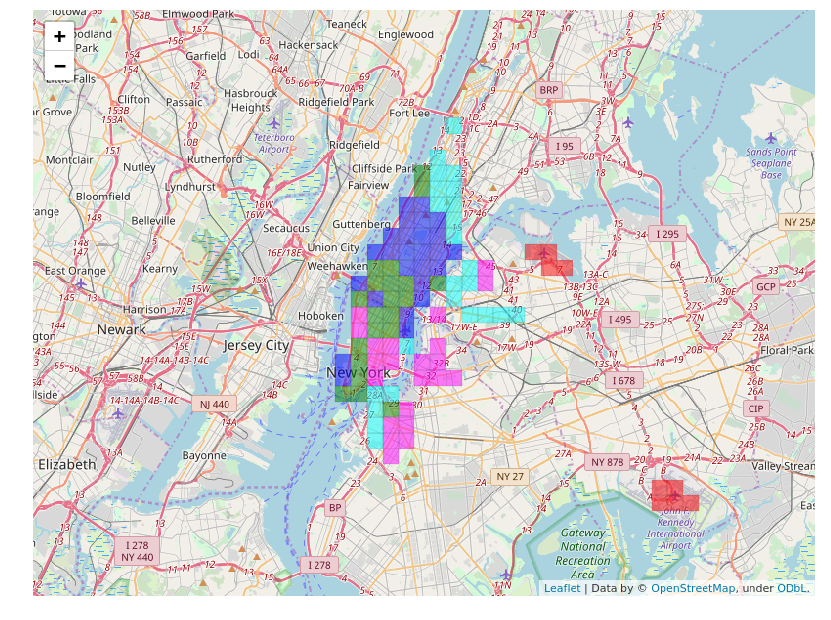

In [138]:
plt.figure(figsize=(14, 11))
map_image = pltimg.imread('maps/map_4_3_2.png')
plt.imshow(map_image)
plt.axis('off')
plt.show()

### 4.3.3. EM.

In [139]:
from sklearn.mixture import GaussianMixture

In [140]:
em_model = GaussianMixture(n_components=5, covariance_type='diag', random_state=random_state)
em_preds = em_model.fit_predict(vals)

In [141]:
Counter(em_preds)

Counter({3: 16, 0: 28, 1: 22, 2: 27, 4: 9})

/home/artem/anaconda3/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


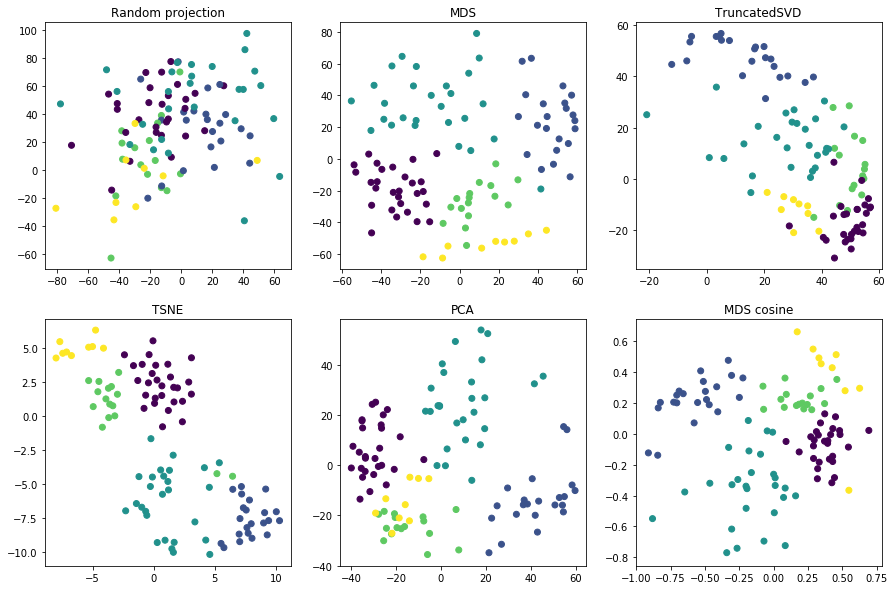

In [142]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
vals = np.array(data_for_clustering).T
random_state = 30
obs = [SparseRandomProjection(2, random_state=random_state), PCA(2, random_state=random_state), 
       TruncatedSVD(2, random_state=random_state), 
       TSNE(2, perplexity=23, learning_rate=200, random_state=random_state), 
       MDS(2, random_state=random_state)]
titles = ['Random projection', 'PCA', 'TruncatedSVD', 'TSNE', 'MDS']
for i in range(len(obs)):
    points = obs[i].fit_transform(vals)
    ax = axs[i%2, i%3]
    ax.scatter([j[0] for j in points], [j[1] for j in points], c=em_preds)
    ax.set_title(titles[i])
mds_model = MDS(n_components=2, dissimilarity='precomputed')
points = mds_model.fit_transform(pairwise_distances(vals, metric='cosine'))
ax = axs[-1, -1]
ax.scatter([j[0] for j in points], [j[1] for j in points], c=em_preds)
ax.set_title('MDS cosine')
plt.show()

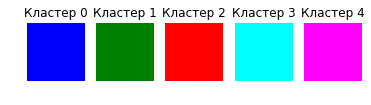

In [143]:
plot_clusters(em_preds, 'map_4_3_3')

PNG

In [144]:
plt.figure(figsize=(14, 11))
map_image = pltimg.imread('maps/map_4_3_3.png')
plt.imshow(map_image)
plt.axis('off')
plt.show()

### 4.3.4. Выбор рассматриваемых рассматриваемых ячеек (по KM-кластеризации).

Примем кластеризацию по KMeans. На картах кластеры выглядят несколько хаотично, но я думаю это не должно смущать, т.к. количество поезок определяется не географическим положением, а преобладающим типом зданий, компаний и т.п.

In [145]:
reg_info = dec_apr_data.iloc[:, :5]
reg_info['cluster'] = km_preds
reg_info.head()

region       west       east      south      north  cluster
0    1075 -74.022246 -74.011135  40.697437  40.705825        1
1    1076 -74.022246 -74.011135  40.705825  40.714213        0
2    1077 -74.022246 -74.011135  40.714213  40.722601        0
3    1125 -74.011135 -74.000023  40.697437  40.705825        1
4    1126 -74.011135 -74.000023  40.705825  40.714213        1

In [146]:
reg_info.shape

(102, 6)

In [147]:
dec_apr_data.head()

region       west       east      south      north  2015-12-01 00:00:00  \
0    1075 -74.022246 -74.011135  40.697437  40.705825                 19.0   
1    1076 -74.022246 -74.011135  40.705825  40.714213                 43.0   
2    1077 -74.022246 -74.011135  40.714213  40.722601                 26.0   
3    1125 -74.011135 -74.000023  40.697437  40.705825                 76.0   
4    1126 -74.011135 -74.000023  40.705825  40.714213                 91.0   

   2015-12-01 01:00:00  2015-12-01 02:00:00  2015-12-01 03:00:00  \
0                 16.0                  8.0                  3.0   
1                 22.0                 19.0                 12.0   
2                 12.0                  3.0                  5.0   
3                 29.0                  9.0                  7.0   
4                 71.0                 21.0                 17.0   

   2015-12-01 04:00:00  ...  2016-04-30 14:00:00  2016-04-30 15:00:00  \
0                  2.0  ...                138.0                145.0   
1                 12.0  ...                318.0                299.0   
2                  3.0  ...                144.0                147.0   
3                  7.0  ...                 91.0                 91.0   
4                 21.0  ...                289.0                287.0   

   2016-04-30 16:00:00  2016-04-30 17:00:00  2016-04-30 18:00:00  \
0                162.0                142.0                157.0   
1                214.0                234.0                223.0   
2                112.0                111.0                124.0   
3                 75.0                 97.0                111.0   
4                264.0                332.0                339.0   

   2016-04-30 19:00:00  2016-04-30 20:00:00  2016-04-30 21:00:00  \
0                121.0                107.0                 91.0   
1                209.0                208.0                155.0   
2                145.0                 99.0                108.0   
3                101.0                107.0                115.0   
4                345.0                290.0                318.0   

   2016-04-30 22:00:00  2016-04-30 23:00:00  
0                100.0                 92.0  
1                 97.0                118.0  
2                 85.0                 63.0  
3                100.0                 86.0  
4                217.0                284.0  

[5 rows x 3653 columns]

In [148]:
reg_info.to_csv('reg_info.csv', sep=',', header=True, index=False)

In [149]:
dec_apr_data['type'] = km_preds

/home/artem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Выберем характерные ячейки по минимальному евклидову расстоянию до центров кластеризации.

In [150]:
target_cells = dict()
for tp in set(km_preds):
    cluster_center = km_model.cluster_centers_[tp]
    type_data = dec_apr_data[dec_apr_data.type == tp]
    min_dist = float('inf')
    for index, row in type_data.iterrows():
        if np.linalg.norm(cluster_center - np.array(row.iloc[5:-1])) < min_dist:
            target_cells[tp] = int(row.region)

In [151]:
dump(target_cells, 'dumps/target_cells.joblib')

['dumps/target_cells.joblib']

In [152]:
for i in target_cells:
    print('Кластер {} - регион {}'.format(i, target_cells[i]))

Кластер 0 - регион 1434
Кластер 1 - регион 1382
Кластер 2 - регион 2168
Кластер 3 - регион 1630
Кластер 4 - регион 1533


Напечатаем графики

In [154]:
for i in target_cells:
    fig, ax = plt.subplots(figsize=(15, 5))
    dec_apr_data[dec_apr_data.region==target_cells[i]].iloc[:, 5:].transpose().plot(ax=ax)
    plt.title('Кластер {}: регион {}'.format(i, target_cells[i]))
    plt.show()

Видны различия между кластерами, пусть в некоторых случаях не так бросающиеся в глаза.

## 4.5. Регрессия, подбор параметров аримы.

По аналогии с прошлым заданием для учёта недельной сезонности используем регрессионные признаки следующего вида:

$$
s_i = \sin \left( [1,\dots,T] * 2 \pi i/ 168 \right),\space c_i = \cos \left( [1,\dots,T] * 2 \pi i/ 168
\right), i=1,\dots, K
$$

Примем К = 20. Также добавим категориальные признаки месяца, дня недели, логарифм количества дней с прошедшего праздника

In [155]:
import holidays
from sklearn.preprocessing import OneHotEncoder
from sklearn import linear_model
from statsmodels import api as sm
from itertools import product
from joblib import dump, load

In [156]:
# Количество дней после ближайшего прошедшего праздника.
def day_after_holiday(day):
    ny_holidays = holidays.CountryHoliday('US', state='NY')
    res = 0
    temp_day = day
    while temp_day not in ny_holidays:
        res += 1
        temp_day = temp_day - datetime.timedelta(days=1)
    return res

In [157]:
# Добавление признаков. 
# Модифицирует датафрейм, возвращеет имена колонок с признаками.
def add_features(cell_data, k, counter=1):
    
    # Синусы и косинусы.
    cell_data['const'] = 1
    cell_data['lin'] = np.arange(counter, cell_data.shape[0]+counter)
    real_columns = ['const', 'lin']
    for i in range(1, k+1):
        #year_sin_col = 'year_sin_{}'.format(i)
        #year_cos_col = 'year_cos_{}'.format(i)
        week_sin_col = 'week_sin_{}'.format(i)
        week_cos_col = 'week_cos_{}'.format(i)
        
        #cell_data[year_sin_col] = np.sin(np.array(cell_data['lin'] * 2 * np.pi * i / 8766))
        #cell_data[year_cos_col] = np.cos(np.array(cell_data['lin'] * 2 * np.pi * i / 8766))
        cell_data[week_sin_col] = np.sin(np.array(cell_data['lin'] * 2 * np.pi * i / 168))
        cell_data[week_cos_col] = np.cos(np.array(cell_data['lin'] * 2 * np.pi * i / 168))
        
        #features_columns += [year_sin_col, year_cos_col, week_sin_col, week_cos_col]
        real_columns += [week_sin_col, week_cos_col]
    
    # Дни недели.
    weekdays = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']
    days = cell_data.index
    days = np.array([i.weekday() + 1 for i in days] + list(range(1, 8)))
    res = OneHotEncoder(sparse=False).fit_transform(days.reshape((-1,1)))[:-7, :]
    for i in range(len(weekdays)):
        cell_data[weekdays[i]] = res[:, i]
    categorical_columns = weekdays
    
    # Месяцы. 
    months_names = ['january', 'february', 'march', 'april', 'may', 'june', 
                'jule', 'august', 'september', 'october', 'november', 'december']
    months = np.array([i.month for i in cell_data.index] + list(range(1, 13)))

    res = OneHotEncoder(sparse=False).fit_transform(months.reshape((-1,1)))[:-12, :]
    for i in range(len(months_names)):
        cell_data[months_names[i]] = res[:, i]
    categorical_columns += months_names
        
 
    # Праздники.
    cell_data['days_after_holidays'] = np.log(np.array([day_after_holiday(i) for i in cell_data.index]) + 1)
    real_columns += ['days_after_holidays']
    
    # Масштабирование.
    #vals = StandardScaler().fit_transform(np.array(cell_data[real_columns]))
    #for i in range(len(real_columns)):
     #   cell_data[real_columns[i]] = vals[:, i]
    
    features_columns = real_columns + categorical_columns
    
    return features_columns

In [158]:
# Обучение модели, добаление предсказаний и остатков в датафрейм. Возвращает модель.
def get_reg_pred(cell_data, features_columns):
    train_data = np.array(cell_data[features_columns])
    train_labels = np.array(cell_data['trips'])
    
    model = linear_model.LinearRegression()
    model.fit(train_data, train_labels)
    
    preds = model.predict(cell_data[features_columns])
    
    cell_data['reg_pred'] = preds
    cell_data['reg_resid'] = cell_data['trips'] - preds
    
    return model

In [159]:
K = 20

In [160]:
dec_apr_data.drop(columns=['type'], inplace=True, errors='ignore')

/home/artem/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


### 4.5.1. Кластер 0.

Регрессия.

In [44]:
cell_data_0 = dec_apr_data[dec_apr_data.region==target_cells[0]].iloc[:, 5:].transpose()
cell_data_0.columns = ['trips']
features_columns_0 = add_features(cell_data_0, K)
reg_model_0 = get_reg_pred(cell_data_0, features_columns_0)
cell_data_0.head()

/home/artem/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/artem/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".


trips  const  lin  week_sin_1  week_cos_1  week_sin_2  \
2015-12-01 00:00:00    1.0      1    1    0.037391    0.999301    0.074730   
2015-12-01 01:00:00    1.0      1    2    0.074730    0.997204    0.149042   
2015-12-01 02:00:00    0.0      1    3    0.111964    0.993712    0.222521   
2015-12-01 03:00:00    0.0      1    4    0.149042    0.988831    0.294755   
2015-12-01 04:00:00    0.0      1    5    0.185912    0.982566    0.365341   

                     week_cos_2  week_sin_3  week_cos_3  week_sin_4  ...  \
2015-12-01 00:00:00    0.997204    0.111964    0.993712    0.149042  ...   
2015-12-01 01:00:00    0.988831    0.222521    0.974928    0.294755  ...   
2015-12-01 02:00:00    0.974928    0.330279    0.943883    0.433884  ...   
2015-12-01 03:00:00    0.955573    0.433884    0.900969    0.563320  ...   
2015-12-01 04:00:00    0.930874    0.532032    0.846724    0.680173  ...   

                     june  jule  august  september  october  november  \
2015-12-01 00:00:00   0.0   0.0     0.0        0.0      0.0       0.0   
2015-12-01 01:00:00   0.0   0.0     0.0        0.0      0.0       0.0   
2015-12-01 02:00:00   0.0   0.0     0.0        0.0      0.0       0.0   
2015-12-01 03:00:00   0.0   0.0     0.0        0.0      0.0       0.0   
2015-12-01 04:00:00   0.0   0.0     0.0        0.0      0.0       0.0   

                     december  days_after_holidays  reg_pred  reg_resid  
2015-12-01 00:00:00       1.0             1.791759  0.293809   0.706191  
2015-12-01 01:00:00       1.0             1.791759 -2.296374   3.296374  
2015-12-01 02:00:00       1.0             1.791759 -2.897643   2.897643  
2015-12-01 03:00:00       1.0             1.791759 -1.130559   1.130559  
2015-12-01 04:00:00       1.0             1.791759  2.721372  -2.721372  

[5 rows x 65 columns]

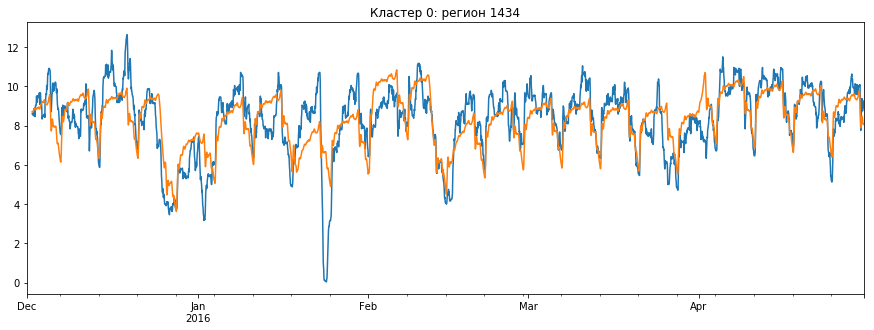

In [45]:
fig, ax = plt.subplots(figsize=(15, 5))
cell_data_0.trips.rolling(24).mean().plot(ax=ax)
cell_data_0.reg_pred.rolling(24).mean().plot(ax=ax)
plt.title('Кластер 0: регион {}'.format(target_cells[0]))
plt.show()

In [46]:
dump(reg_model_0, 'dumps/reg_model_0.joblib')

['dumps/reg_model_0.joblib']

Преобразование остатков от регрессии.

In [47]:
def plot_decompose(cell_data_0, col):
    dec_obj = sm.tsa.seasonal_decompose(cell_data_0[col].dropna())
    fig, ax = plt.subplots(figsize=(15, 5))
    dec_obj.observed.plot(ax=ax)
    plt.title('Observed'.format(i, target_cells[i]))
    plt.show()
    fig, ax = plt.subplots(figsize=(15, 5))
    dec_obj.trend.plot(ax=ax)
    plt.title('Trend'.format(i, target_cells[i]))
    plt.show()
    fig, ax = plt.subplots(figsize=(15, 5))
    dec_obj.seasonal.plot(ax=ax)
    plt.title('Seasonal'.format(i, target_cells[i]))
    plt.show()
    fig, ax = plt.subplots(figsize=(15, 5))
    dec_obj.resid.plot(ax=ax)
    plt.title('Resid'.format(i, target_cells[i]))
    plt.show()

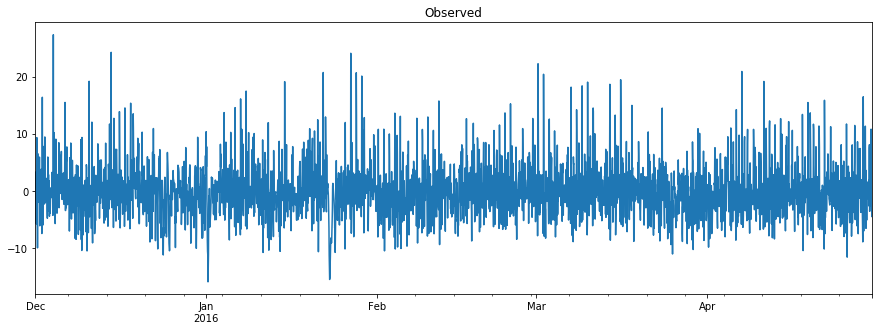

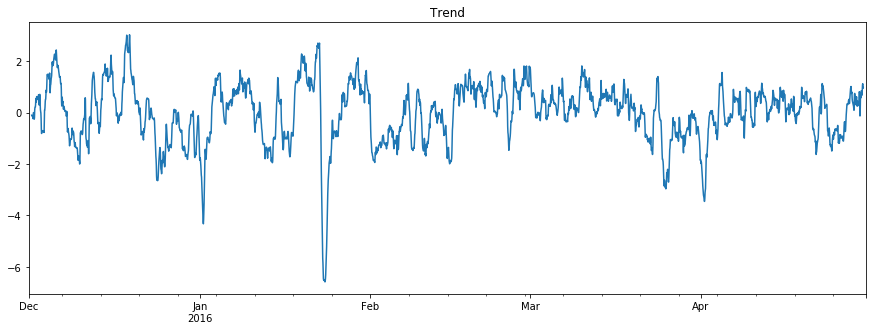

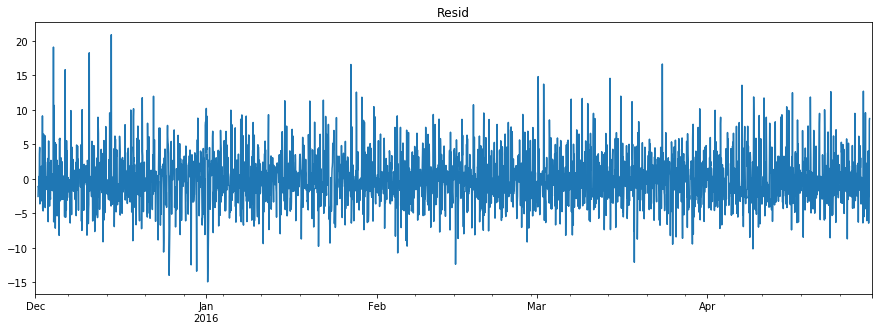

In [48]:
plot_decompose(cell_data_0, 'reg_resid')

Выполним одно сезонное дифференцирование, затем одно обычное.

In [49]:
cell_data_0['reg_resid_diff'] = cell_data_0.reg_resid - cell_data_0.reg_resid.shift(24)
cell_data_0['reg_resid_diff'] = cell_data_0['reg_resid_diff'] - cell_data_0['reg_resid_diff'].shift(1)

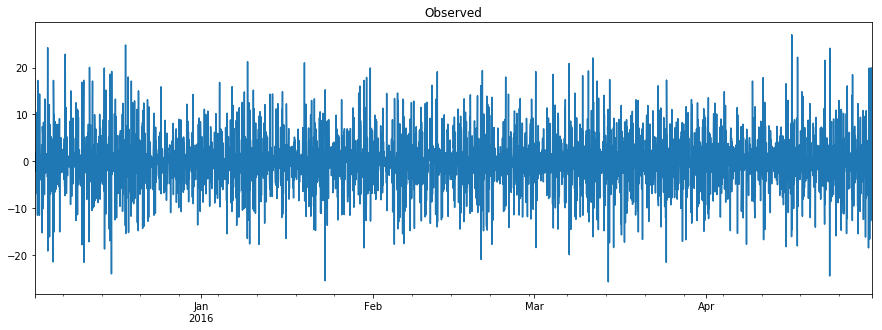

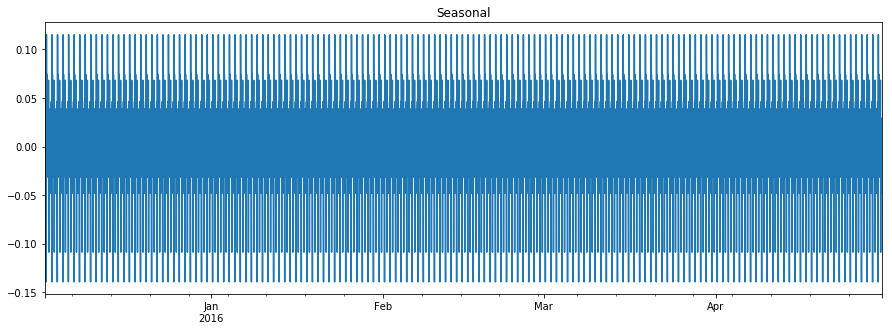

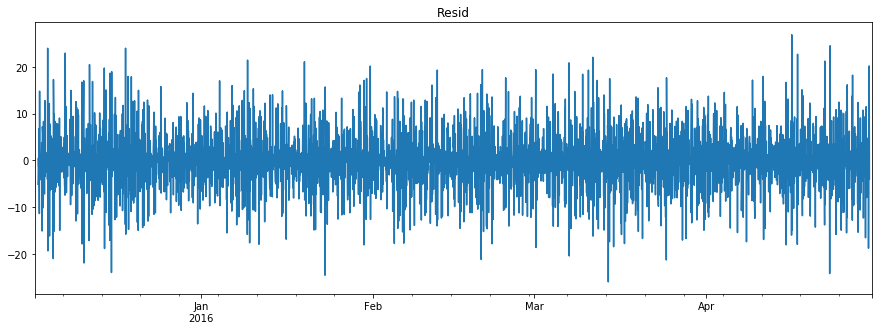

In [50]:
plot_decompose(cell_data_0, 'reg_resid_diff')

Подберём параметры модели SARIMAX.

In [51]:
d = 1; D = 1

In [52]:
def plot_corr(data, lags, cor='acf'):
    fig, ax = plt.subplots(figsize=(15, 5))
    if cor == 'acf':
        sm.graphics.tsa.plot_acf(data.dropna().values.squeeze(), lags=lags, ax=ax)
    elif cor == 'pacf':
        sm.graphics.tsa.plot_pacf(data.dropna().values.squeeze(), lags=lags, ax=ax)
    ax.xaxis.set_ticks(np.arange(0, lags, 10))
    plt.show()

In [53]:
plot_corr(cell_data_0['reg_resid_diff'], 90 , 'acf')

In [54]:
q = 23; Q = 1

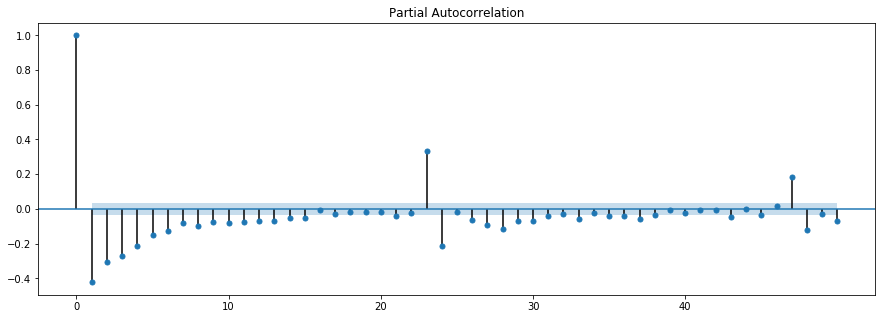

In [55]:
plot_corr(cell_data_0['reg_resid_diff'], 50 , 'pacf')

In [56]:
plot_corr(cell_data_0['reg_resid_diff'], 171 , 'pacf')

In [57]:
p = 15; P = 6

In [58]:
ps = list(range(p+1))
qs = list(range(q+1))
Ps = list(range(P+1))
Qs = list(range(Q+1))
parameters_0 = product(ps, [d], qs, Ps, [D], Qs)
parameters_0 = list(parameters_0)
len(parameters_0)

5376

### 4.5.2. Кластер 1.

Регрессия.

In [59]:
cell_data_1 = dec_apr_data[dec_apr_data.region==target_cells[1]].iloc[:, 5:].transpose()
cell_data_1.columns = ['trips']
features_columns_1 = add_features(cell_data_1, K)
reg_model_1 = get_reg_pred(cell_data_1, features_columns_1)

/home/artem/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/artem/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".


In [60]:
fig, ax = plt.subplots(figsize=(15, 5))
cell_data_1.trips.rolling(24).mean().plot(ax=ax)
cell_data_1.reg_pred.rolling(24).mean().plot(ax=ax)
plt.title('Кластер 1: регион {}'.format(target_cells[1]))
plt.show()

In [61]:
dump(reg_model_1, 'dumps/reg_model_1.joblib')

['dumps/reg_model_1.joblib']

Преобразование остатков от регрессии.

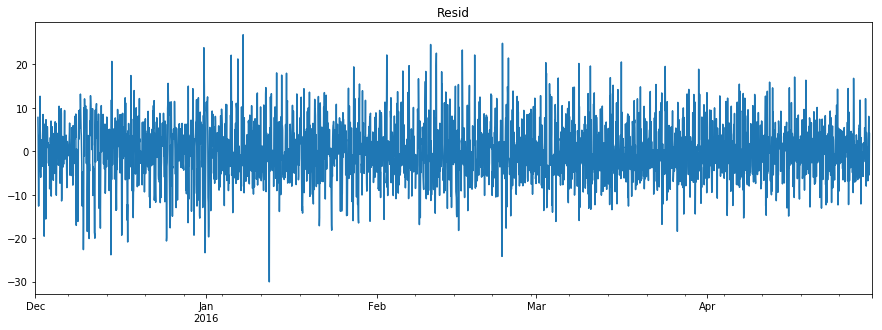

In [62]:
plot_decompose(cell_data_1, 'reg_resid')

Выполним одно сезонное дифференцирование, затем одно обычное.

In [63]:
cell_data_1['reg_resid_diff'] = cell_data_1.reg_resid - cell_data_1.reg_resid.shift(24)
cell_data_1['reg_resid_diff'] = cell_data_1['reg_resid_diff'] - cell_data_1['reg_resid_diff'].shift(1)

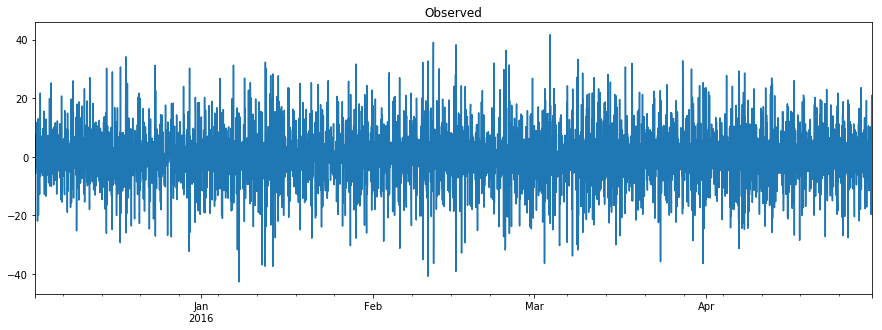

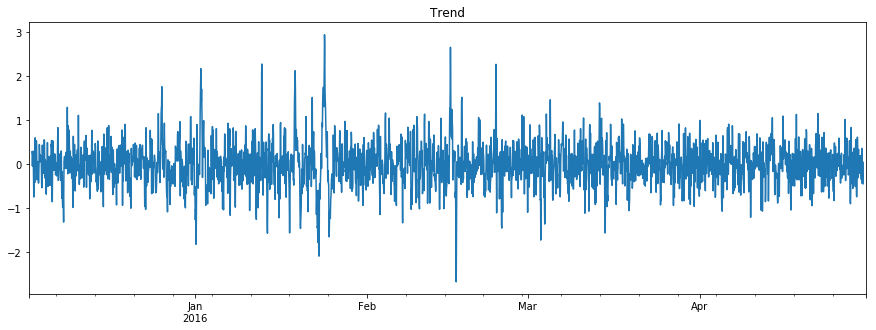

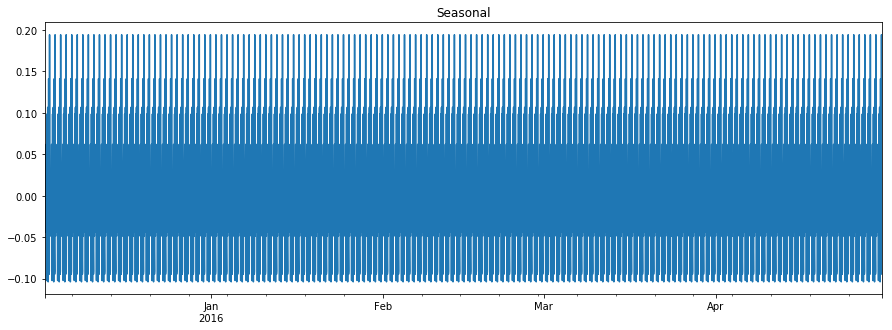

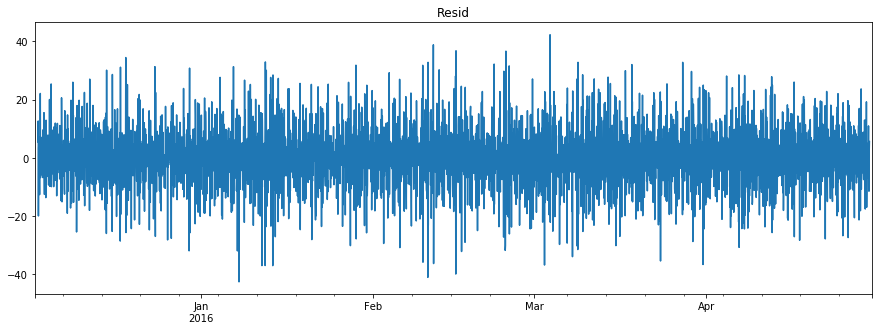

In [64]:
plot_decompose(cell_data_1, 'reg_resid_diff')

Подберём параметры модели SARIMAX.

In [65]:
d = 1; D = 1

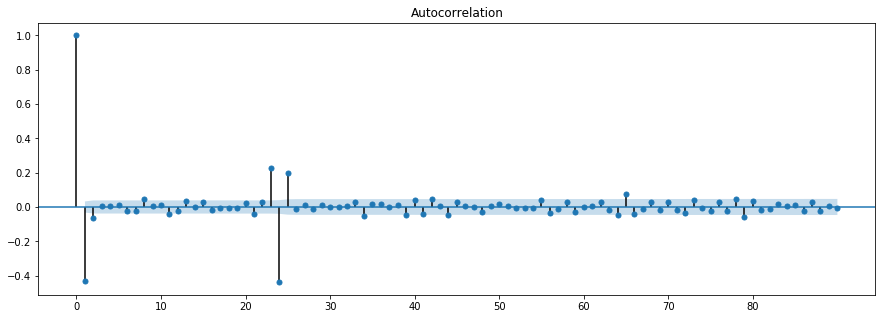

In [66]:
plot_corr(cell_data_1['reg_resid_diff'], 90 , 'acf')

In [67]:
q = 23; Q = 1

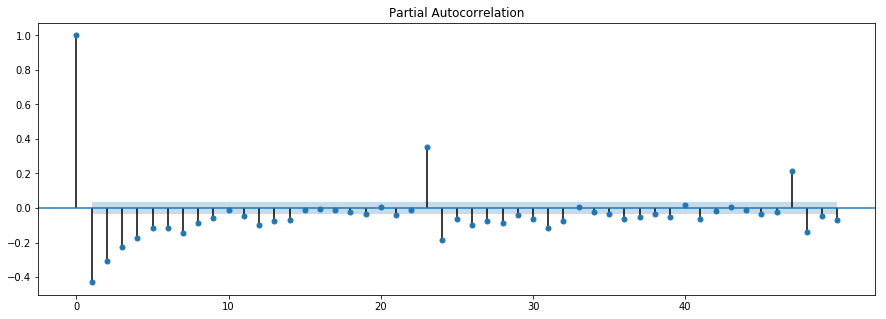

In [68]:
plot_corr(cell_data_1['reg_resid_diff'], 50 , 'pacf')

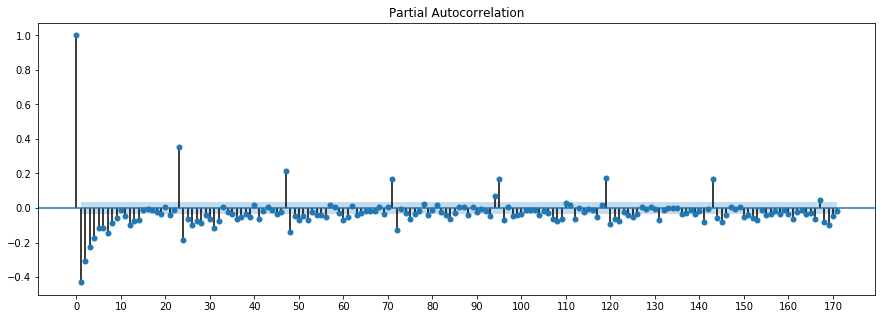

In [69]:
plot_corr(cell_data_1['reg_resid_diff'], 171 , 'pacf')

In [70]:
p = 14; P = 6

In [71]:
ps = list(range(p+1))
qs = list(range(q+1))
Ps = list(range(P+1))
Qs = list(range(Q+1))
parameters_1 = product(ps, [d], qs, Ps, [D], Qs)
parameters_1 = list(parameters_1)
len(parameters_1)

5040

### 4.5.3. Кластер 2.

Регрессия.

In [72]:
cell_data_2 = dec_apr_data[dec_apr_data.region==target_cells[2]].iloc[:, 5:].transpose()
cell_data_2.columns = ['trips']
features_columns_2 = add_features(cell_data_2, K)
reg_model_2 = get_reg_pred(cell_data_2, features_columns_2)

/home/artem/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/artem/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".


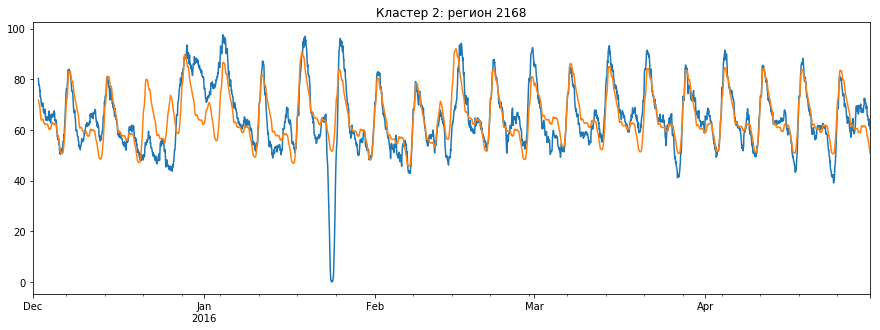

In [73]:
fig, ax = plt.subplots(figsize=(15, 5))
cell_data_2.trips.rolling(24).mean().plot(ax=ax)
cell_data_2.reg_pred.rolling(24).mean().plot(ax=ax)
plt.title('Кластер 2: регион {}'.format(target_cells[2]))
plt.show()

In [74]:
dump(reg_model_2, 'dumps/reg_model_2.joblib')

['dumps/reg_model_2.joblib']

Преобразование остатков от регрессии.

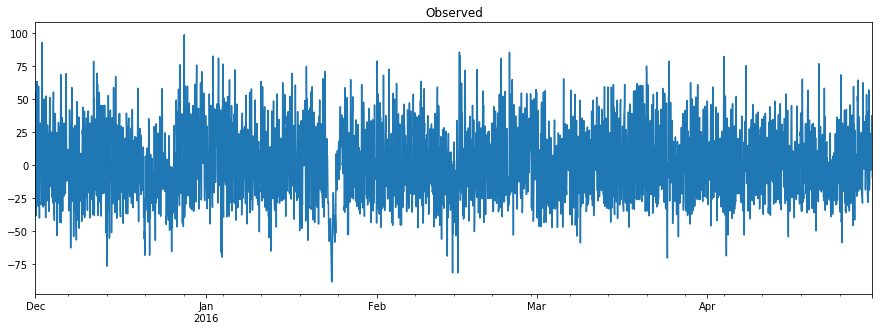

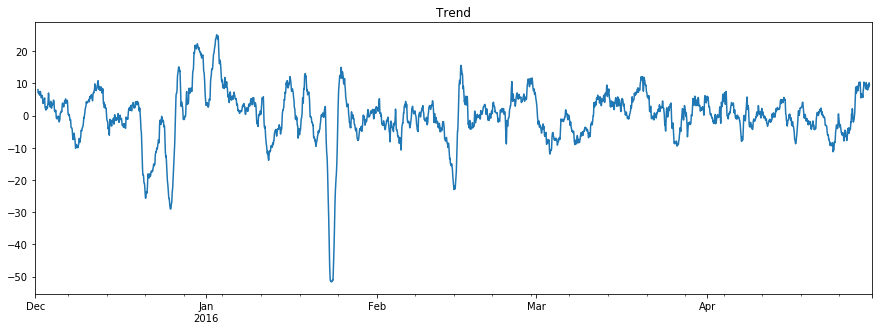

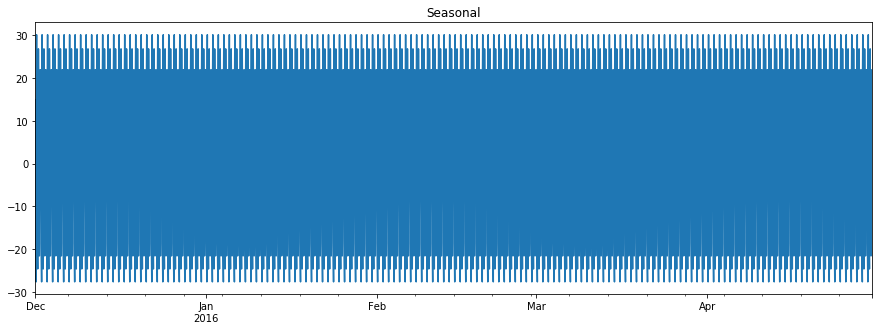

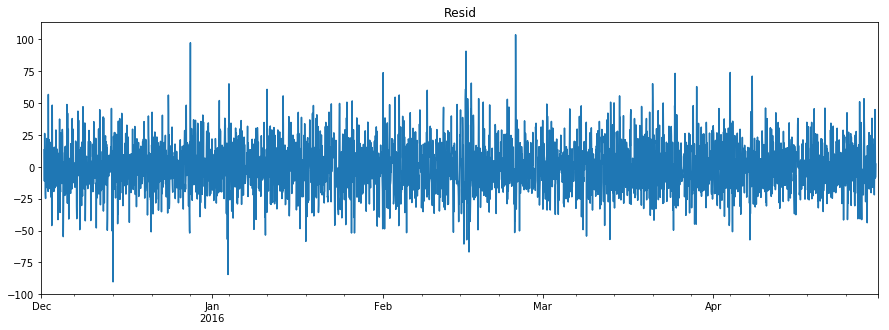

In [75]:
plot_decompose(cell_data_2, 'reg_resid')

Выполним одно сезонное дифференцирование, затем одно обычное.

In [76]:
cell_data_2['reg_resid_diff'] = cell_data_2.reg_resid - cell_data_2.reg_resid.shift(24)
cell_data_2['reg_resid_diff'] = cell_data_2['reg_resid_diff'] - cell_data_2['reg_resid_diff'].shift(1)

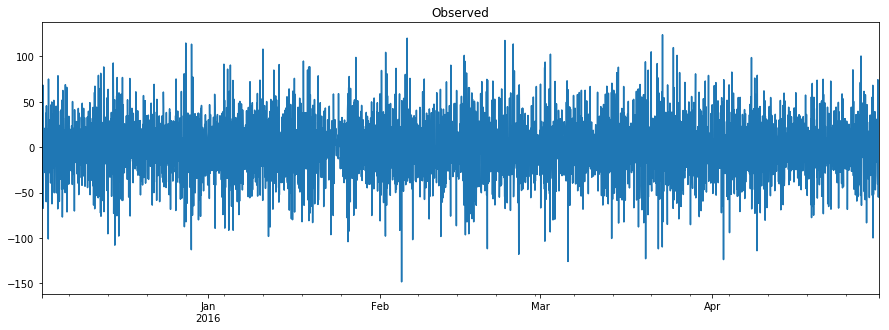

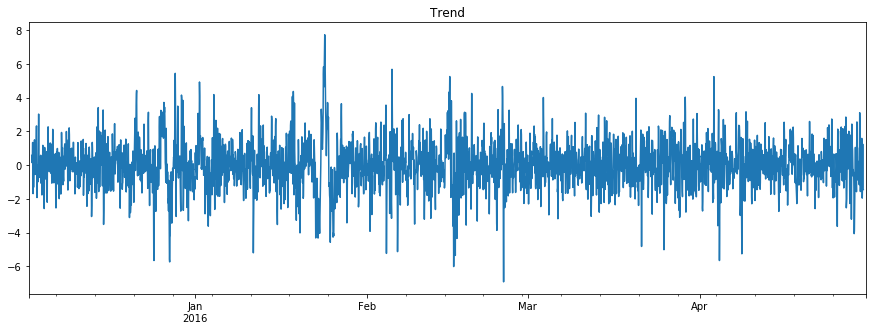

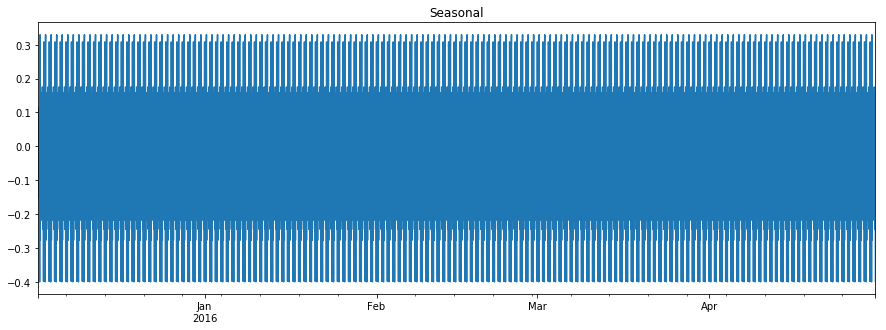

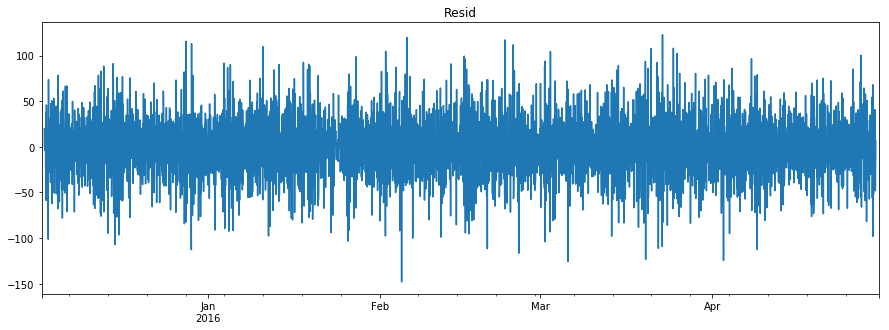

In [77]:
plot_decompose(cell_data_2, 'reg_resid_diff')

Подберём параметры модели SARIMAX.

In [78]:
d = 1; D = 1

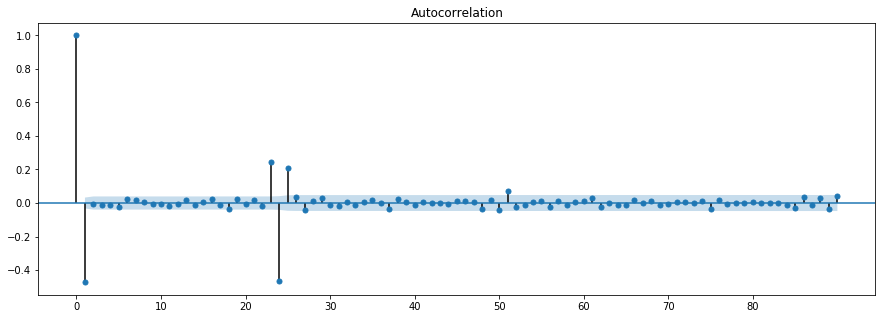

In [79]:
plot_corr(cell_data_2['reg_resid_diff'], 90 , 'acf')

In [80]:
q = 23; Q = 1

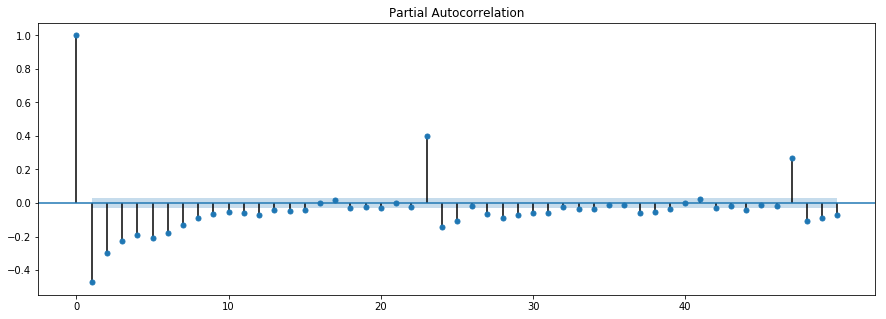

In [81]:
plot_corr(cell_data_2['reg_resid_diff'], 50 , 'pacf')

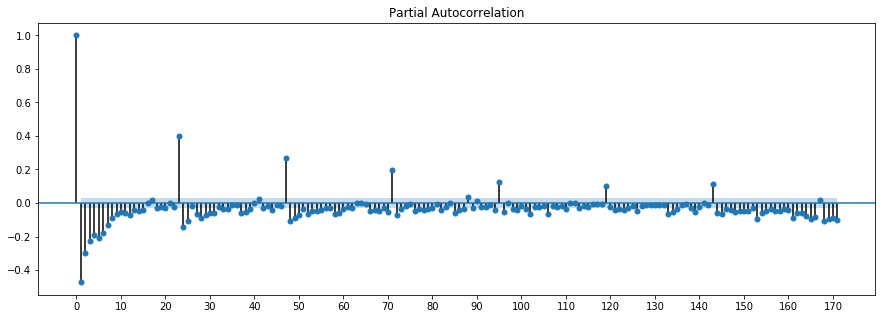

In [82]:
plot_corr(cell_data_2['reg_resid_diff'], 171 , 'pacf')

In [83]:
p = 15; P = 7

In [84]:
ps = list(range(p+1))
qs = list(range(q+1))
Ps = list(range(P+1))
Qs = list(range(Q+1))
parameters_2 = product(ps, [d], qs, Ps, [D], Qs)
parameters_2 = list(parameters_2)
len(parameters_2)

6144

## 4.5.4. Кластер 3.

Регрессия.

In [85]:
cell_data_3 = dec_apr_data[dec_apr_data.region==target_cells[3]].iloc[:, 5:].transpose()
cell_data_3.columns = ['trips']
features_columns_3 = add_features(cell_data_3, K)
reg_model_3 = get_reg_pred(cell_data_3, features_columns_3)

/home/artem/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/artem/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".


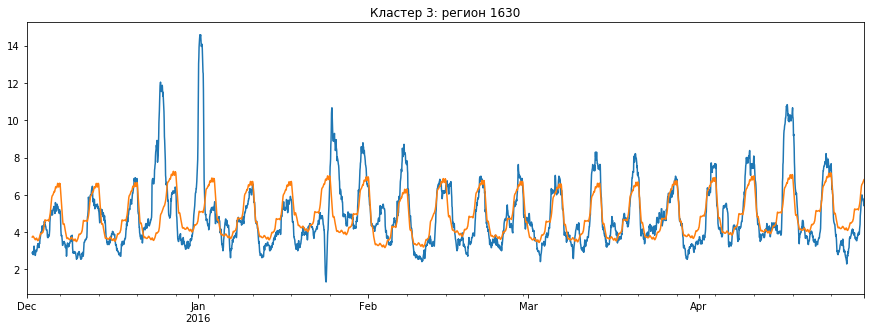

In [86]:
fig, ax = plt.subplots(figsize=(15, 5))
cell_data_3.trips.rolling(24).mean().plot(ax=ax)
cell_data_3.reg_pred.rolling(24).mean().plot(ax=ax)
plt.title('Кластер 3: регион {}'.format(target_cells[3]))
plt.show()

In [87]:
dump(reg_model_3, 'dumps/reg_model_3.joblib')

['dumps/reg_model_3.joblib']

Преобразование остатков от регрессии.

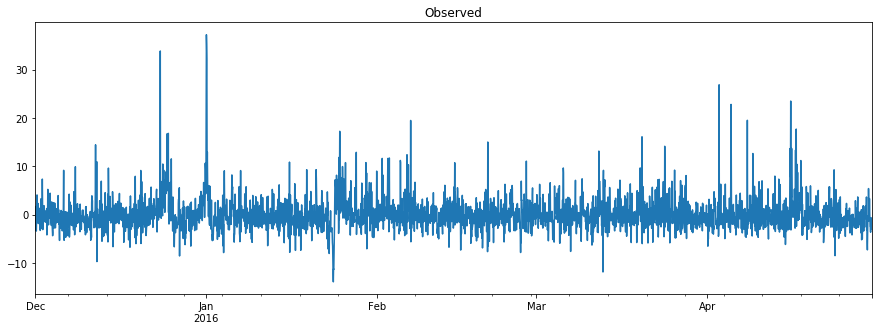

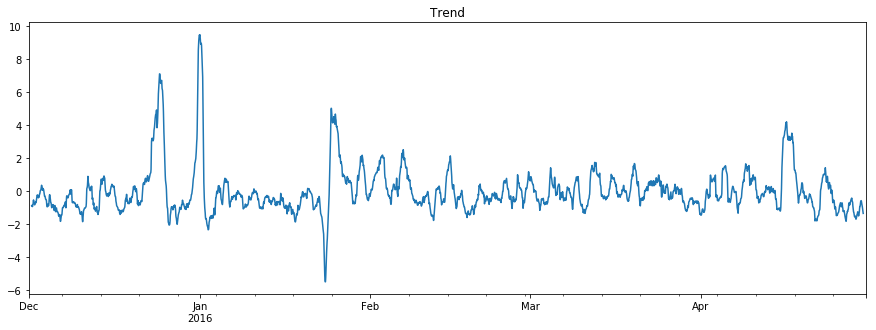

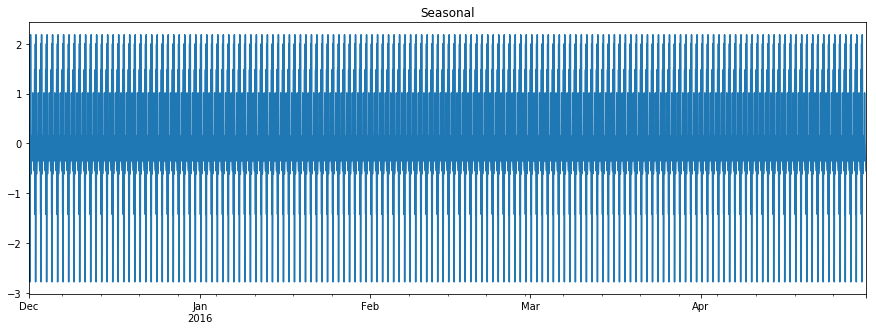

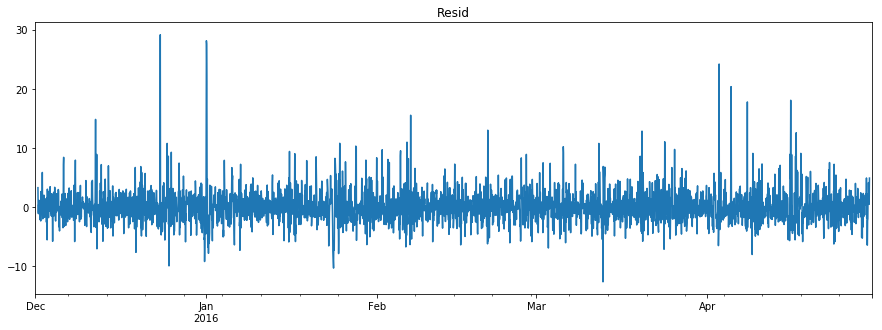

In [88]:
plot_decompose(cell_data_3, 'reg_resid')

Выполним одно сезонное дифференцирование, затем одно обычное.

In [89]:
cell_data_3['reg_resid_diff'] = cell_data_3.reg_resid - cell_data_3.reg_resid.shift(24)
cell_data_3['reg_resid_diff'] = cell_data_3['reg_resid_diff'] - cell_data_3['reg_resid_diff'].shift(1)

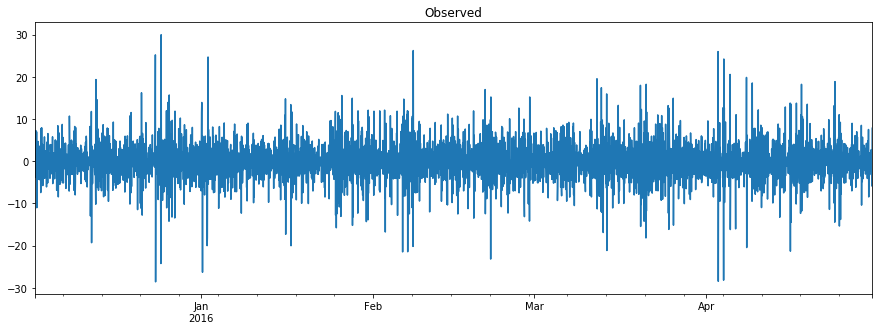

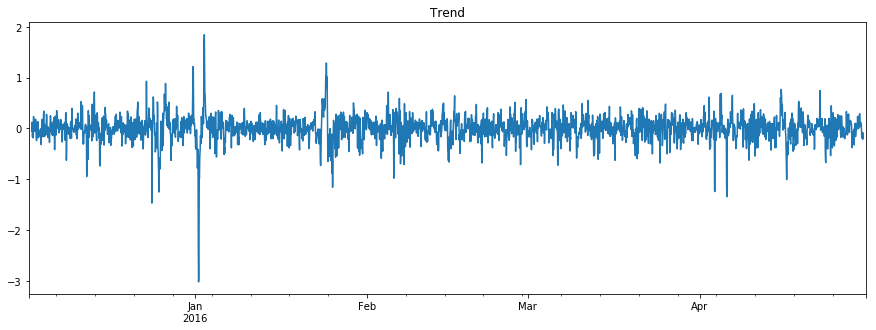

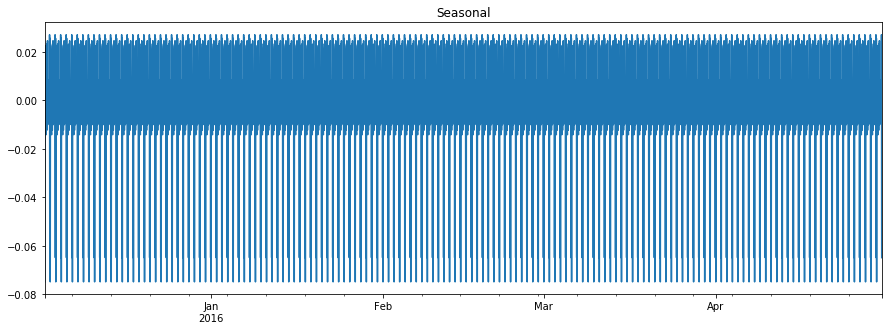

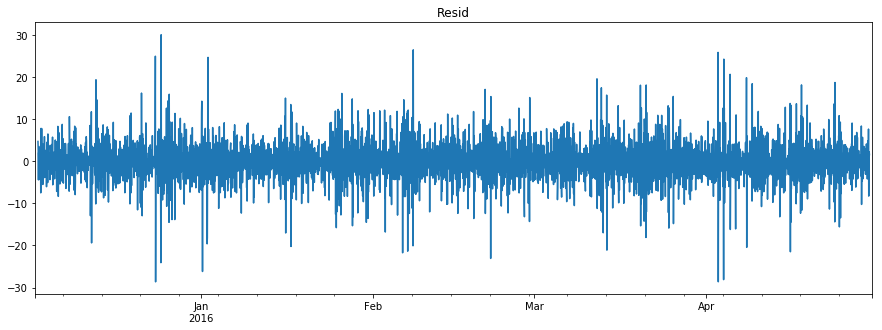

In [90]:
plot_decompose(cell_data_3, 'reg_resid_diff')

Подберём параметры модели SARIMAX.

In [91]:
d = 1; D = 1

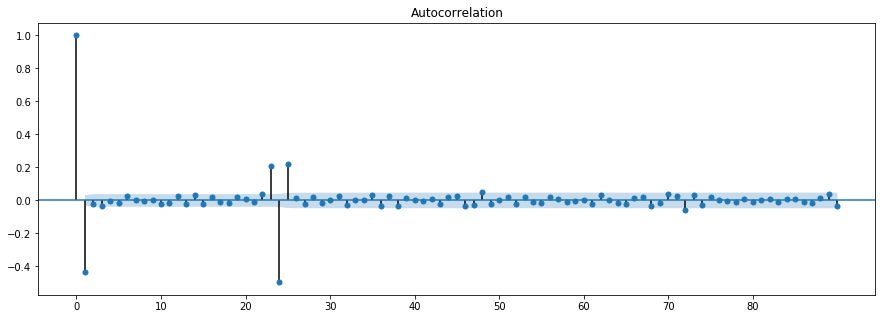

In [92]:
plot_corr(cell_data_3['reg_resid_diff'], 90 , 'acf')

In [93]:
q = 23; Q = 1

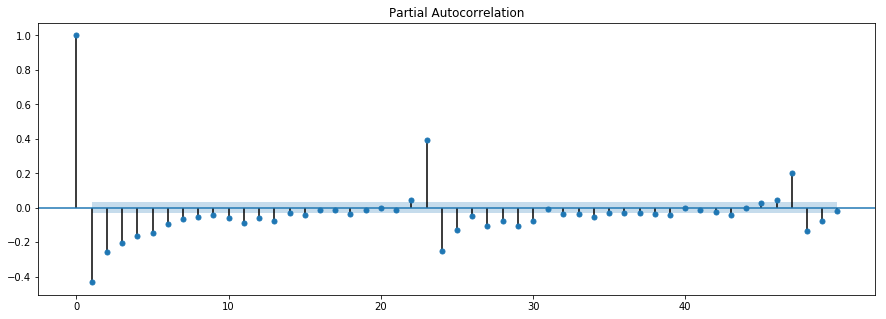

In [94]:
plot_corr(cell_data_3['reg_resid_diff'], 50 , 'pacf')

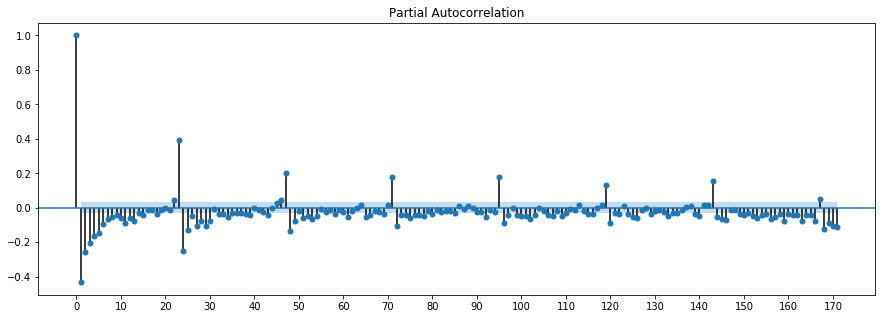

In [95]:
plot_corr(cell_data_3['reg_resid_diff'], 171 , 'pacf')

In [96]:
p = 13; P = 7

In [97]:
ps = list(range(p+1))
qs = list(range(q+1))
Ps = list(range(P+1))
Qs = list(range(Q+1))
parameters_3 = product(ps, [d], qs, Ps, [D], Qs)
parameters_3 = list(parameters_3)
len(parameters_3)

5376

### 4.5.5. Кластер 4.

Регрессия.

In [98]:
cell_data_4 = dec_apr_data[dec_apr_data.region==target_cells[4]].iloc[:, 5:].transpose()
cell_data_4.columns = ['trips']
features_columns_4 = add_features(cell_data_4, K)
reg_model_4 = get_reg_pred(cell_data_4, features_columns_4)

/home/artem/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/artem/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".


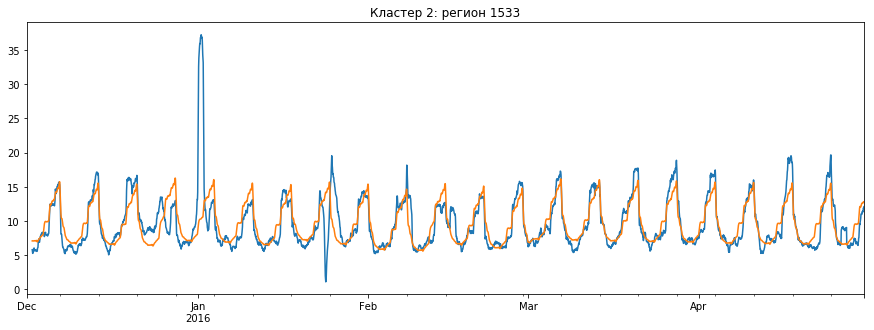

In [99]:
fig, ax = plt.subplots(figsize=(15, 5))
cell_data_4.trips.rolling(24).mean().plot(ax=ax)
cell_data_4.reg_pred.rolling(24).mean().plot(ax=ax)
plt.title('Кластер 2: регион {}'.format(target_cells[4]))
plt.show()

In [100]:
dump(reg_model_4, 'dumps/reg_model_4.joblib')

['dumps/reg_model_4.joblib']

Преобразование остатков от регрессии.

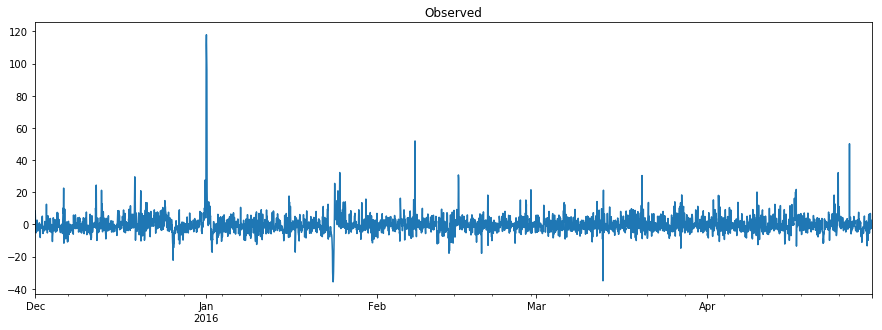

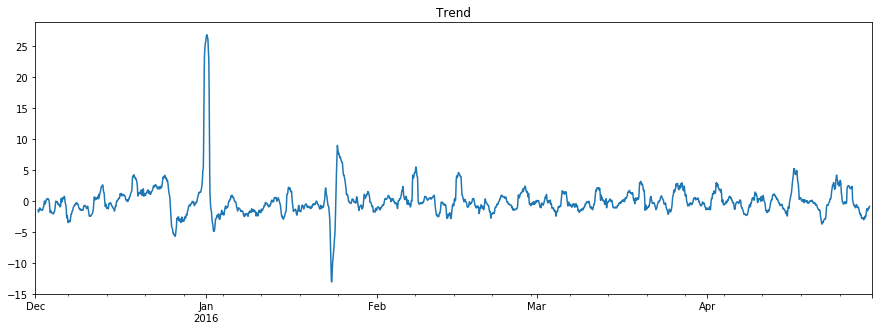

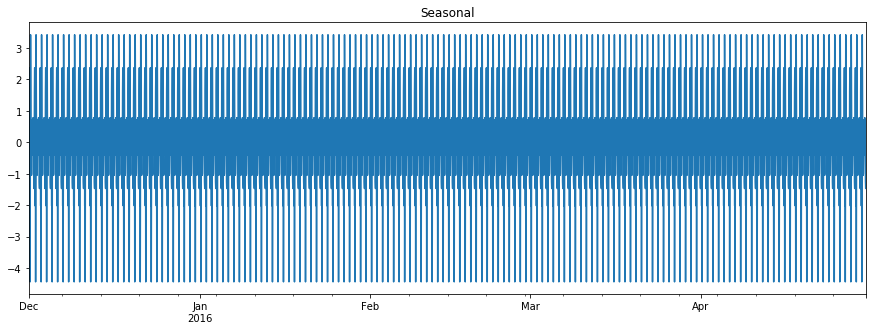

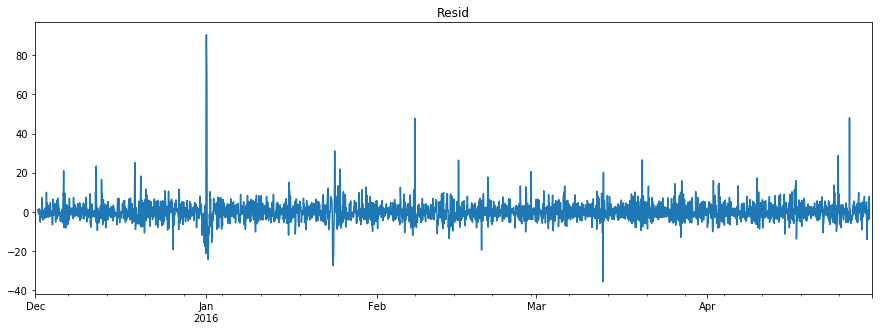

In [101]:
plot_decompose(cell_data_4, 'reg_resid')

Выполним одно сезонное дифференцирование, затем одно обычное.

In [102]:
cell_data_4['reg_resid_diff'] = cell_data_4.reg_resid - cell_data_4.reg_resid.shift(24)
cell_data_4['reg_resid_diff'] = cell_data_4['reg_resid_diff'] - cell_data_4['reg_resid_diff'].shift(1)

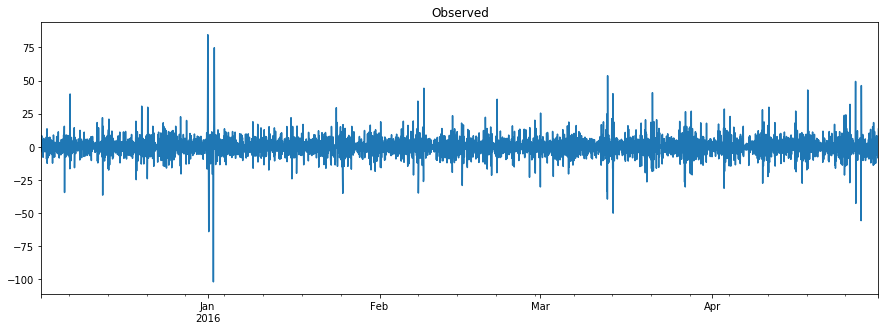

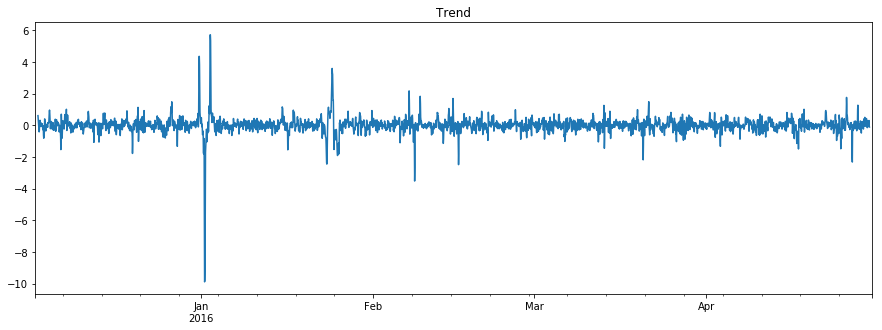

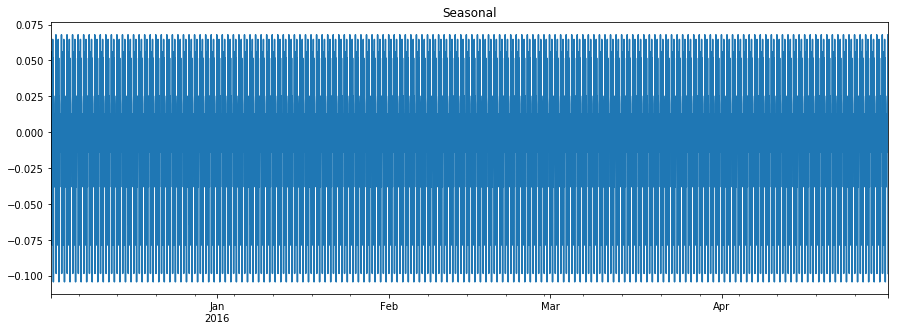

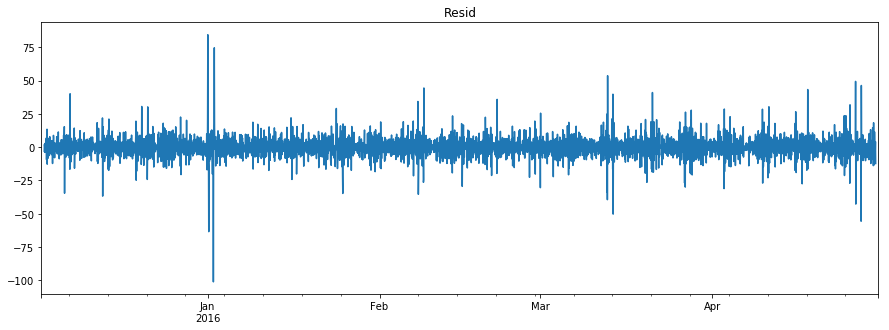

In [103]:
plot_decompose(cell_data_4, 'reg_resid_diff')

Подберём параметры модели SARIMAX.

In [104]:
d = 1; D = 1

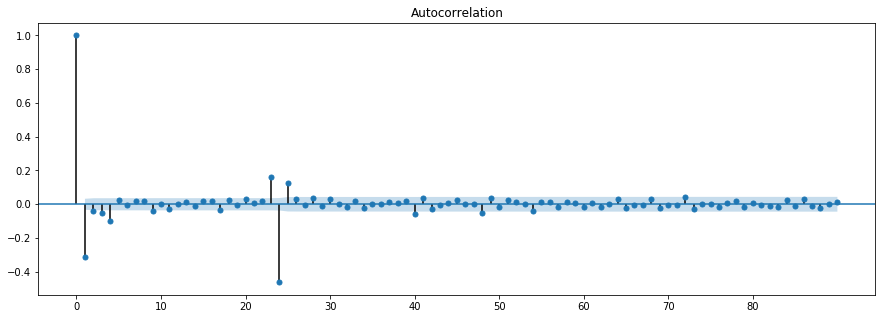

In [105]:
plot_corr(cell_data_4['reg_resid_diff'], 90 , 'acf')

In [106]:
q = 23; Q = 1

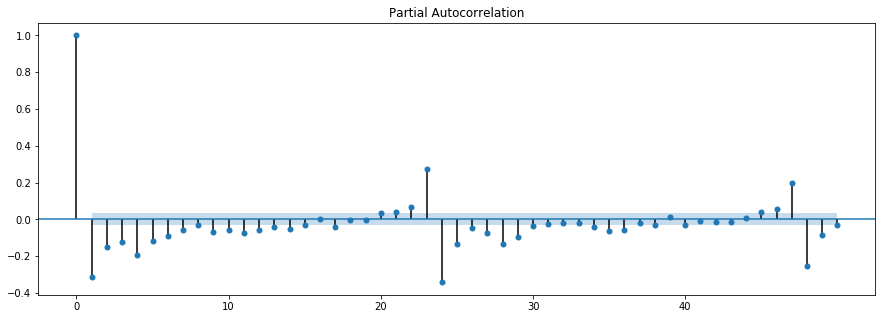

In [107]:
plot_corr(cell_data_4['reg_resid_diff'], 50 , 'pacf')

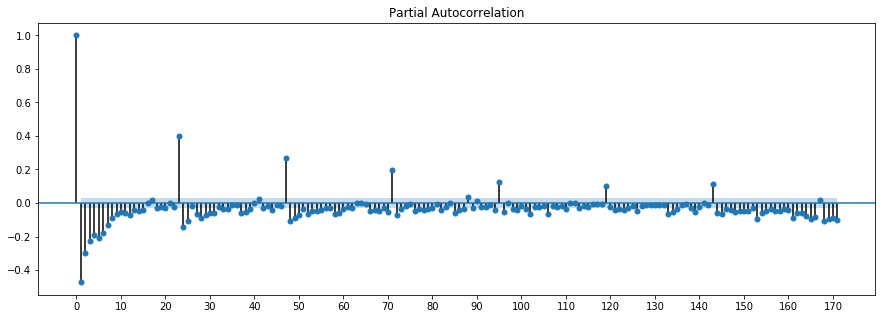

In [108]:
plot_corr(cell_data_2['reg_resid_diff'], 171 , 'pacf')

In [109]:
p = 23; P = 7

In [110]:
ps = list(range(p+1))
qs = list(range(q+1))
Ps = list(range(P+1))
Qs = list(range(Q+1))
parameters_4 = product(ps, [d], qs, Ps, [D], Qs)
parameters_4 = list(parameters_4)
len(parameters_4)

9216

## 4.6. Настройка SARIMAX.

Перебирать все варианты параметров не будем, ограничим время перебора циклов. Раздел выполнялся на другом компьютере, котрый перезагрузили перед сохранением записки, поэтому в ячейках кластеров 3 и 4 пустой вывод. Однако дампы сделаться успели, модели настроились, можно посмотреть на графики предсказаний по этим кластерам в разделе 4.7.

In [111]:
import warnings
from joblib import dump
from scipy import stats as sts

### 4.6.1. Кластер 0.

In [95]:
np.random.shuffle(parameters_0)

In [96]:
#print('Всего', str(len(parameters_0)))
#i = 0
best_aic = float('inf')
start = datetime.datetime.now().timestamp()
for param in parameters_0:
    #i += 1
    #print(i, '-', param, '...', datetime.datetime.now(), '...')
    try:
        model = sm.tsa.statespace.SARIMAX(cell_data_0['reg_resid'], order=(param[0], param[1], param[2]), 
                                        seasonal_order=(param[3], param[4], param[5], 24)).fit()
    
    except ValueError or np.linalg.LinAlgError or np.linalg.linalg.LinAlgError:
        #print('...WRONG')
        continue
    aic_res = model.aic
    if aic_res < best_aic:
        best_model = model
        best_aic = aic_res
        best_param = param
    if (datetime.datetime.now().timestamp() - start) / 3600 > 2:
        break

C:\Users\XpyweI3\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\XpyweI3\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
C:\Users\XpyweI3\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [97]:
dump(best_param, 'dumps/orders_0.joblib')
dump(best_model.params, 'dumps/params_0.joblib')

['params_0.joblib']

In [98]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                          reg_resid   No. Observations:                 3648
Model:             SARIMAX(8, 1, 4)x(6, 1, 0, 24)   Log Likelihood               -9885.406
Date:                            Fri, 31 May 2019   AIC                          19808.812
Time:                                    02:43:38   BIC                          19926.518
Sample:                                12-01-2015   HQIC                         19850.746
                                     - 04-30-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2524      0.148     -8.479      0.000      -1.542      -0.963
ar.L2         -1.1567      0.053    -21.671      0.000      -1.261      -1.052
ar.L3         -0.5837      0.130     -4.492      0.000      -0.838      -0.329
ar.L4          0.3047      0.045      6.793      0.000       0.217       0.393
ar.L5          0.1864      0.036      5.247      0.000       0.117       0.256
ar.L6          0.1760      0.039      4.567      0.000       0.100       0.251
ar.L7          0.1272      0.031      4.070      0.000       0.066       0.188
ar.L8          0.0377      0.021      1.784      0.074      -0.004       0.079
ma.L1          0.4567      0.146      3.133      0.002       0.171       0.743
ma.L2          0.0250      0.070      0.355      0.723      -0.113       0.163
ma.L3         -0.5456      0.069     -7.889      0.000      -0.681      -0.410
ma.L4         -0.9314      0.144     -6.446      0.000      -1.215      -0.648
ar.S.L24      -0.7310      0.013    -55.347      0.000      -0.757      -0.705
ar.S.L48      -0.5965      0.016    -38.466      0.000      -0.627      -0.566
ar.S.L72      -0.5462      0.016    -34.060      0.000      -0.578      -0.515
ar.S.L96      -0.4932      0.016    -31.772      0.000      -0.524      -0.463
ar.S.L120     -0.4143      0.016    -26.323      0.000      -0.445      -0.383
ar.S.L144     -0.2292      0.013    -17.699      0.000      -0.255      -0.204
sigma2        13.5038      0.233     57.923      0.000      13.047      13.961
===================================================================================
Ljung-Box (Q):                       60.76   Jarque-Bera (JB):               681.99
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                             0.43
Prob(H) (two-sided):                  0.21   Kurtosis:                         4.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

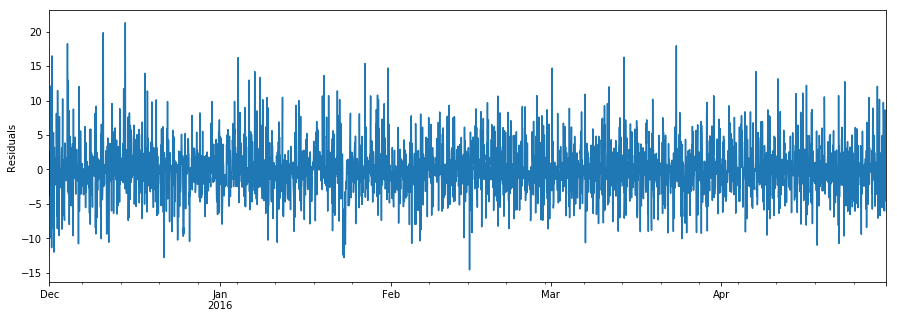

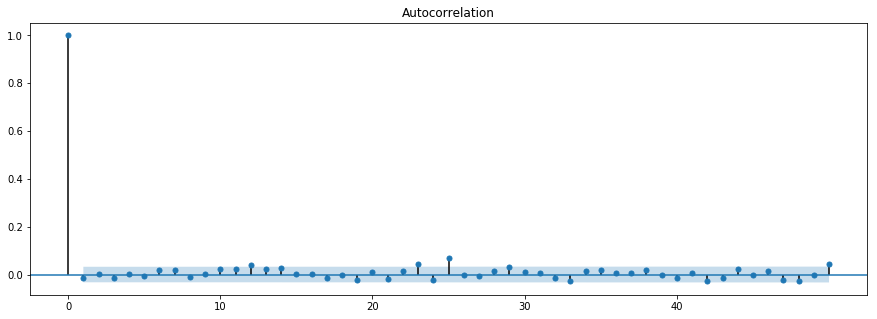

Критерий Стьюдента: p=0.70
Критерий Дики-Фуллера: p=0.00
Критерий Льюнга-Бокса: p=0.02


In [99]:
plt.figure(figsize=(15,5))
best_model.resid.plot()
plt.ylabel('Residuals')
plt.show()

plot_corr(best_model.resid, 50, 'acf')

print('Критерий Стьюдента: p={:.2f}'.format(sts.ttest_1samp(best_model.resid.dropna(), 0)[1]))
print('Критерий Дики-Фуллера: p={:.2f}'.format(sm.tsa.stattools.adfuller(best_model.resid.dropna())[1]))
print('Критерий Льюнга-Бокса: p={:.2f}'.format(float(str(best_model.summary().tables[2]).split()[8])))

In [100]:
dump(best_model.resid, 'dumps/sarmx_resid_0.joblib')

['sarmx_resid_0.joblib']

In [101]:
best_model = None

### 4.6.2. Кластер 1.

In [102]:
np.random.shuffle(parameters_1)

In [103]:
#print('Всего', str(len(parameters_1)))
#i = 0
best_aic = float('inf')
start = datetime.datetime.now().timestamp()
for param in parameters_1:
    #i += 1
    #print(i, '-', param, '...', datetime.datetime.now(), '...')
    try:
        model = sm.tsa.statespace.SARIMAX(cell_data_1['reg_resid'], order=(param[0], param[1], param[2]), 
                                        seasonal_order=(param[3], param[4], param[5], 24)).fit()
    
    except ValueError or np.linalg.LinAlgError or np.linalg.linalg.LinAlgError:
        #print('...WRONG')
        continue
    aic_res = model.aic
    if aic_res < best_aic:
        best_model = model
        best_aic = aic_res
        best_param = param
    if (datetime.datetime.now().timestamp() - start) / 3600 > 2:
        break

C:\Users\XpyweI3\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\XpyweI3\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
C:\Users\XpyweI3\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\XpyweI3\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\XpyweI3\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

In [ ]:
dump(best_param, 'dumps/orders_1.joblib')
dump(best_model.params, 'dumps/params_1.joblib')

['params_1.joblib']

In [ ]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                          reg_resid   No. Observations:                 3648
Model:             SARIMAX(4, 1, 7)x(3, 1, 1, 24)   Log Likelihood              -11898.874
Date:                            Fri, 31 May 2019   AIC                          23829.748
Time:                                    05:10:33   BIC                          23928.869
Sample:                                12-01-2015   HQIC                         23865.061
                                     - 04-30-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5434      0.303     -1.796      0.073      -1.136       0.050
ar.L2         -0.5590      0.184     -3.037      0.002      -0.920      -0.198
ar.L3         -0.6128      0.214     -2.860      0.004      -1.033      -0.193
ar.L4         -0.5560      0.192     -2.889      0.004      -0.933      -0.179
ma.L1         -0.1726      0.302     -0.571      0.568      -0.765       0.420
ma.L2          0.0354      0.343      0.103      0.918      -0.638       0.709
ma.L3          0.1056      0.310      0.341      0.733      -0.501       0.713
ma.L4         -0.0204      0.228     -0.089      0.929      -0.468       0.427
ma.L5         -0.5417      0.155     -3.502      0.000      -0.845      -0.239
ma.L6         -0.1802      0.038     -4.757      0.000      -0.254      -0.106
ma.L7         -0.0887      0.031     -2.828      0.005      -0.150      -0.027
ar.S.L24       0.1353      0.017      8.194      0.000       0.103       0.168
ar.S.L48       0.0144      0.016      0.921      0.357      -0.016       0.045
ar.S.L72      -0.0443      0.016     -2.728      0.006      -0.076      -0.012
ma.S.L24      -0.9552      0.006   -159.642      0.000      -0.967      -0.943
sigma2        40.9515      0.804     50.955      0.000      39.376      42.527
===================================================================================
Ljung-Box (Q):                      113.90   Jarque-Bera (JB):               161.27
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

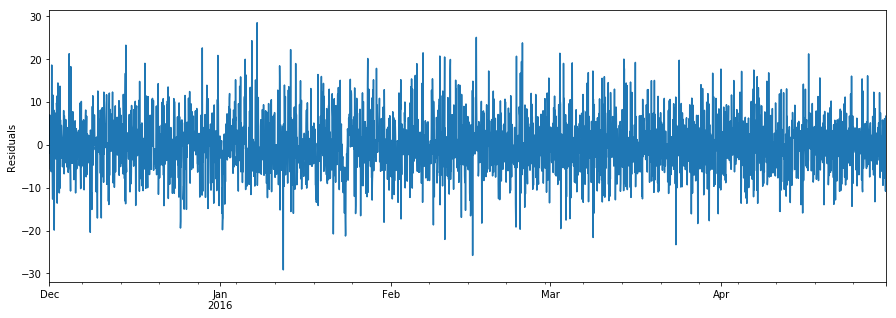

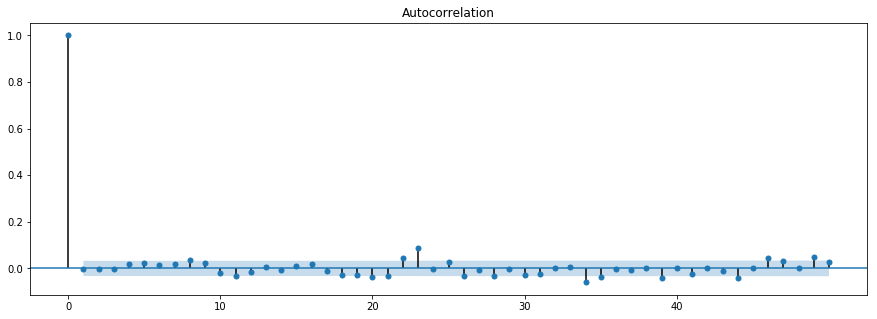

Критерий Стьюдента: p=0.84
Критерий Дики-Фуллера: p=0.00
Критерий Льюнга-Бокса: p=0.00


In [ ]:
plt.figure(figsize=(15,5))
best_model.resid.plot()
plt.ylabel('Residuals')
plt.show()

plot_corr(best_model.resid, 50, 'acf')

print('Критерий Стьюдента: p={:.2f}'.format(sts.ttest_1samp(best_model.resid.dropna(), 0)[1]))
print('Критерий Дики-Фуллера: p={:.2f}'.format(sm.tsa.stattools.adfuller(best_model.resid.dropna())[1]))
print('Критерий Льюнга-Бокса: p={:.2f}'.format(float(str(best_model.summary().tables[2]).split()[8])))

In [ ]:
dump(best_model.resid, 'dumps/sarmx_resid_1.joblib')

['sarmx_resid_1.joblib']

In [ ]:
best_model = None

### 4.6.3. Кластер 2.

In [ ]:
np.random.shuffle(parameters_2)

In [ ]:
#print('Всего', str(len(parameters_2)))
#i = 0
best_aic = float('inf')
start = datetime.datetime.now().timestamp()
for param in parameters_2:
    #i += 1
    #print(i, '-', param, '...', datetime.datetime.now(), '...')
    try:
        model = sm.tsa.statespace.SARIMAX(cell_data_2['reg_resid'], order=(param[0], param[1], param[2]), 
                                        seasonal_order=(param[3], param[4], param[5], 24)).fit()
    
    except ValueError or np.linalg.LinAlgError or np.linalg.linalg.LinAlgError:
        #print('...WRONG')
        continue
    aic_res = model.aic
    if aic_res < best_aic:
        best_model = model
        best_aic = aic_res
        best_param = param
    if (datetime.datetime.now().timestamp() - start) / 3600 > 2:
        break

C:\Users\XpyweI3\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\XpyweI3\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
C:\Users\XpyweI3\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\XpyweI3\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\XpyweI3\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 

In [ ]:
dump(best_param, 'dumps/orders_2.joblib')
dump(best_model.params, 'dumps/params_2.joblib')

['params_2.joblib']

In [ ]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  Statespace Model Results                                  
============================================================================================
Dep. Variable:                            reg_resid   No. Observations:                 3648
Model:             SARIMAX(10, 1, 20)x(3, 1, 1, 24)   Log Likelihood              -16022.954
Date:                              Fri, 31 May 2019   AIC                          32115.908
Time:                                      08:26:02   BIC                          32332.735
Sample:                                  12-01-2015   HQIC                         32193.155
                                       - 04-30-2016                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -3.8540      0.272    -14.177      0.000      -4.387      -3.321
ar.L2         -8.5057      0.917     -9.278      0.000     -10.303      -6.709
ar.L3        -13.8512      1.831     -7.563      0.000     -17.441     -10.262
ar.L4        -17.8561      2.788     -6.404      0.000     -23.321     -12.391
ar.L5        -19.0407      3.326     -5.724      0.000     -25.560     -12.521
ar.L6        -16.8968      3.305     -5.113      0.000     -23.374     -10.419
ar.L7        -12.2375      2.715     -4.507      0.000     -17.559      -6.916
ar.L8         -6.9668      1.748     -3.985      0.000     -10.394      -3.540
ar.L9         -2.8146      0.853     -3.301      0.001      -4.486      -1.143
ar.L10        -0.5985      0.235     -2.546      0.011      -1.059      -0.138
ma.L1          3.0192      3.142      0.961      0.337      -3.139       9.178
ma.L2          5.2242     12.599      0.415      0.678     -19.470      29.918
ma.L3          6.4776     28.956      0.224      0.823     -50.276      63.231
ma.L4          5.5914     49.237      0.114      0.910     -90.911     102.094
ma.L5          2.8161     66.741      0.042      0.966    -127.994     133.626
ma.L6         -0.9190     75.562     -0.012      0.990    -149.019     147.181
ma.L7         -4.1131     72.692     -0.057      0.955    -146.586     138.360
ma.L8         -5.3306     59.822     -0.089      0.929    -122.579     111.918
ma.L9         -4.4592     43.130     -0.103      0.918     -88.992      80.074
ma.L10        -2.4188     29.157     -0.083      0.934     -59.565      54.727
ma.L11        -0.6018     21.571     -0.028      0.978     -42.880      41.676
ma.L12        -0.0261     19.682     -0.001      0.999     -38.603      38.550
ma.L13        -0.4077     19.602     -0.021      0.983     -38.828      38.012
ma.L14        -0.9711     18.329     -0.053      0.958     -36.895      34.953
ma.L15        -1.3703     15.292     -0.090      0.929     -31.342      28.601
ma.L16        -1.3971     11.004     -0.127      0.899     -22.964      20.170
ma.L17        -1.0929      6.629     -0.165      0.869     -14.085      11.899
ma.L18        -0.6584      3.204     -0.206      0.837      -6.937       5.621
ma.L19        -0.2844      1.139     -0.250      0.803      -2.516       1.947
ma.L20        -0.0780      0.245     -0.318      0.751      -0.559       0.403
ar.S.L24       0.1976      0.021      9.569      0.000       0.157       0.238
ar.S.L48       0.0633      0.019      3.397      0.001       0.027       0.100
ar.S.L72       0.0925      0.018      5.256      0.000       0.058       0.127
ma.S.L24      -0.9873      0.006   -155.802      0.000      -1.000      -0.975
sigma2       422.6011   1323.115      0.319      0.749   -2170.658    3015.860
===================================================================================
Ljung-Box (Q):               

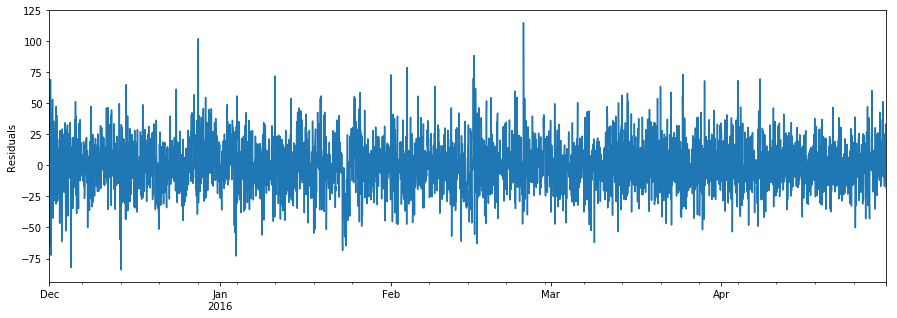

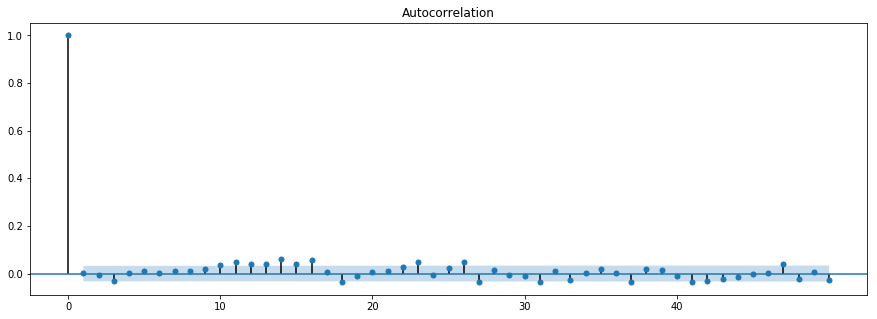

Критерий Стьюдента: p=0.14
Критерий Дики-Фуллера: p=0.00
Критерий Льюнга-Бокса: p=0.00


In [ ]:
plt.figure(figsize=(15,5))
best_model.resid.plot()
plt.ylabel('Residuals')
plt.show()

plot_corr(best_model.resid, 50, 'acf')

print('Критерий Стьюдента: p={:.2f}'.format(sts.ttest_1samp(best_model.resid.dropna(), 0)[1]))
print('Критерий Дики-Фуллера: p={:.2f}'.format(sm.tsa.stattools.adfuller(best_model.resid.dropna())[1]))
print('Критерий Льюнга-Бокса: p={:.2f}'.format(float(str(best_model.summary().tables[2]).split()[8])))

In [ ]:
dump(best_model.resid, 'dumps/sarmx_resid_2.joblib')

['sarmx_resid_2.joblib']

In [ ]:
best_model = None

### 4.6.4. Кластер 3.

In [113]:
np.random.shuffle(parameters_3)

In [ ]:
#print('Всего', str(len(parameters_3)))
#i = 0
best_aic = float('inf')
start = datetime.datetime.now().timestamp()
for param in parameters_3:
    #i += 1
    #print(i, '-', param, '...', datetime.datetime.now(), '...')
    try:
        model = sm.tsa.statespace.SARIMAX(cell_data_3['reg_resid'], order=(param[0], param[1], param[2]), 
                                        seasonal_order=(param[3], param[4], param[5], 24)).fit(maxiter=15)
    
    except ValueError or np.linalg.LinAlgError or np.linalg.linalg.LinAlgError:
        #print('...WRONG')
        continue
    aic_res = model.aic
    if aic_res < best_aic:
        best_model = model
        best_aic = aic_res
        best_param = param
    if (datetime.datetime.now().timestamp() - start) / 3600 > 2:
        break

C:\Users\XpyweI3\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\XpyweI3\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
C:\Users\XpyweI3\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\XpyweI3\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\XpyweI3\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. C

In [ ]:
dump(best_param, 'dumps/orders_3.joblib')
dump(best_model.params, 'dumps/params_3.joblib')

In [ ]:
best_model.summary()

In [ ]:
plt.figure(figsize=(15,5))
best_model.resid.plot()
plt.ylabel('Residuals')
plt.show()

plot_corr(best_model.resid, 50, 'acf')

print('Критерий Стьюдента: p={:.2f}'.format(sts.ttest_1samp(best_model.resid.dropna(), 0)[1]))
print('Критерий Дики-Фуллера: p={:.2f}'.format(sm.tsa.stattools.adfuller(best_model.resid.dropna())[1]))
print('Критерий Льюнга-Бокса: p={:.2f}'.format(float(str(best_model.summary().tables[2]).split()[8])))

In [ ]:
dump(best_model.resid, 'dumps/sarmx_resid_3.joblib')

In [ ]:
best_model = None

### 4.6.5. Кластер 4.

In [ ]:
np.random.shuffle(parameters_4)

In [ ]:
#print('Всего', str(len(parameters_4)))
#i = 0
best_aic = float('inf')
start = datetime.datetime.now().timestamp()
for param in parameters_4:
    #i += 1
    #print(i, '-', param, '...', datetime.datetime.now(), '...')
    try:
        model = sm.tsa.statespace.SARIMAX(cell_data_4['reg_resid'], order=(param[0], param[1], param[2]), 
                                        seasonal_order=(param[3], param[4], param[5], 24)).fit(maxiter=15)
    
    except ValueError or np.linalg.LinAlgError or np.linalg.linalg.LinAlgError:
        #print('...WRONG')
        continue
    aic_res = model.aic
    if aic_res < best_aic:
        best_model = model
        best_aic = aic_res
        best_param = param
    if (datetime.datetime.now().timestamp() - start) / 3600 > 2:
        break

In [ ]:
dump(best_param, 'dumps/orders_4.joblib')
dump(best_model.params, 'dumps/params_4.joblib')

In [ ]:
best_model.summary()

In [ ]:
plt.figure(figsize=(15,5))
best_model.resid.plot()
plt.ylabel('Residuals')
plt.show()

plot_corr(best_model.resid, 50, 'acf')

print('Критерий Стьюдента: p={:.2f}'.format(sts.ttest_1samp(best_model.resid.dropna(), 0)[1]))
print('Критерий Дики-Фуллера: p={:.2f}'.format(sm.tsa.stattools.adfuller(best_model.resid.dropna())[1]))
print('Критерий Льюнга-Бокса: p={:.2f}'.format(float(str(best_model.summary().tables[2]).split()[8])))

In [ ]:
dump(best_model.resid, 'dumps/sarmx_resid_4.joblib')

In [ ]:
best_model = None

## 4.7. Построение прогнозов на май 2016г.

Для каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 построим прогноз на 6 часов вперёд и посчитаем ошибку прогноза по следующему функционалу: 

$$Q_{may}=\frac{1}{R∗739∗6}\sum_{r=1}^{R}\sum_{T=2016.04.3023:00}^{2016.05.3117:00}\sum_{i=1}^{6}∣\widehat{y}^{r}_{T|T+i}−{y}^{r}_{T+i}| $$

Сперва построим графики и посчитаем ошибки для 5 выше рассмотренных зон.

Кластер 0 ... 20:35


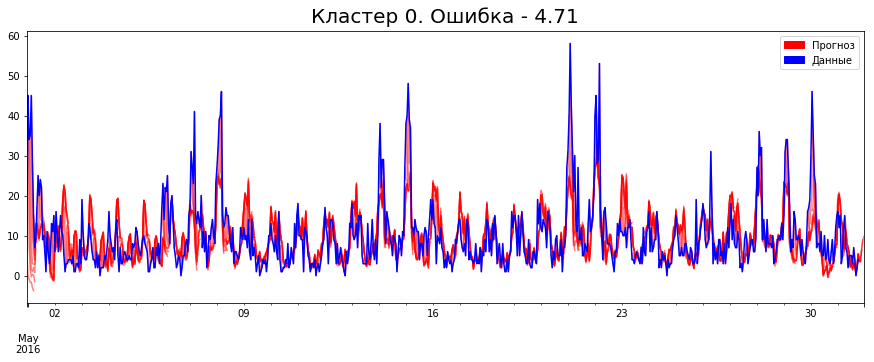

Кластер 1 ... 21:44


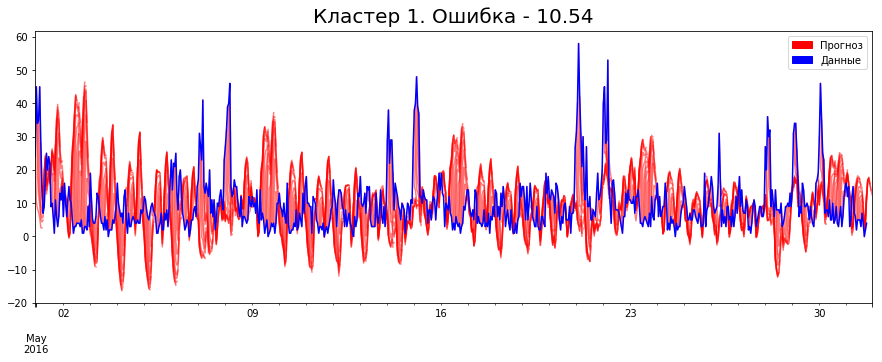

Кластер 2 ... 22:05


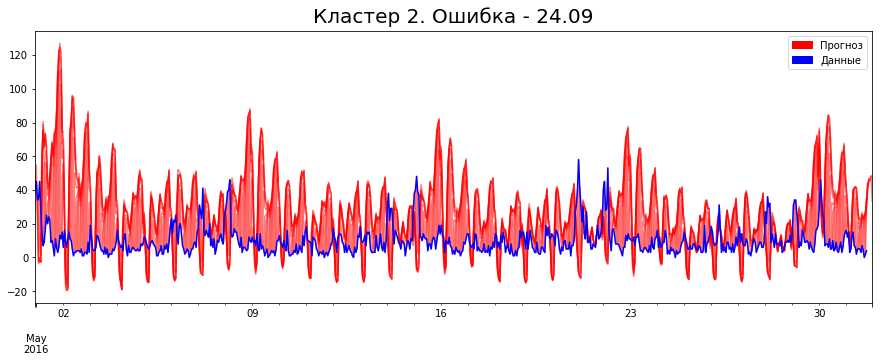

Кластер 3 ... 22:30


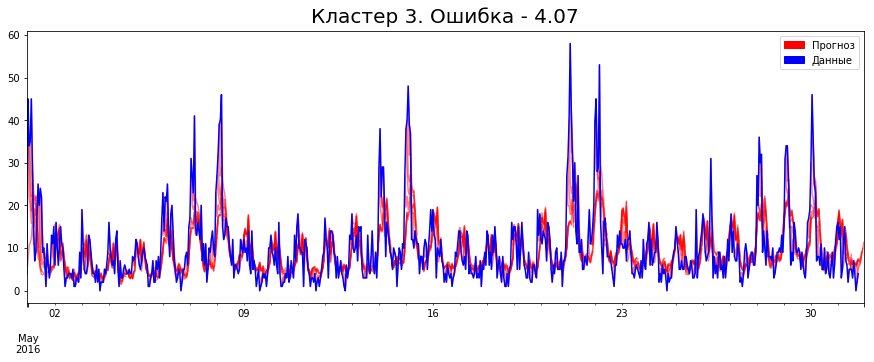

Кластер 4 ... 22:50


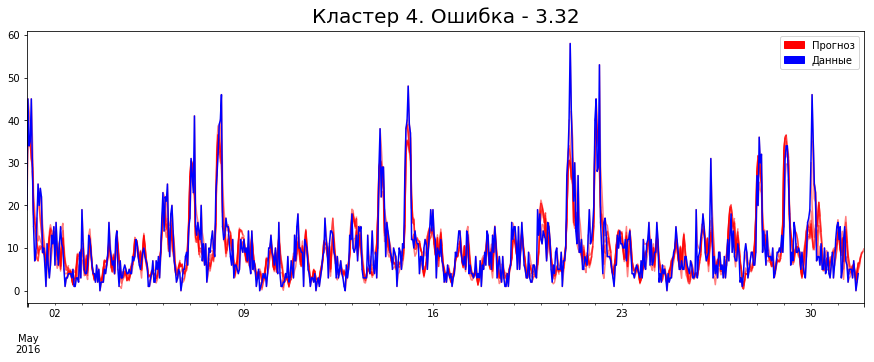

CPU times: user 3h 35min 31s, sys: 1h 21min 11s, total: 4h 56min 43s
Wall time: 2h 28min 27s


In [112]:
%%time
warnings.filterwarnings('ignore')

regs_err = dict()

ERR = 0
target_data = may_data[may_data.region==target_cells[tp]].iloc[:, 5:].transpose()
target_data.columns = ['trips']
for tp in target_cells:
    
    print('Кластер {} ...'.format(tp), datetime.datetime.now().strftime('%H:%M'))
        
    CLUSTER_ERR = 0
    fig, ax = plt.subplots(figsize=(15, 5))
    
    params = load('dumps/params_{}.joblib'.format(tp))
    orders = load('dumps/orders_{}.joblib'.format(tp))
    reg_model = load('dumps/reg_model_{}.joblib'.format(tp))
    
    # Предскажем остатки от регрессии.
    cell_data = dec_apr_data[dec_apr_data.region == target_cells[tp]].iloc[:, 5:].transpose()
    cell_data.columns = ['trips']
    feature_columns = add_features(cell_data, 20)
    _ = add_features(target_data, 20, cell_data.shape[0]+1)
    cell_data = cell_data.append(target_data)
    cell_data['reg_pred'] = reg_model.predict(np.array(cell_data[feature_columns]))
    cell_data['reg_resid'] = np.array(cell_data.trips) - np.array(cell_data.reg_pred)
    
    # SARIMAX
    srmx = sm.tsa.statespace.SARIMAX(cell_data['reg_resid'], 
                                     order=(orders[0], orders[1], orders[2]), 
                                     seasonal_order=(orders[3], orders[4], orders[5], 24)).filter(params)
    
    start_hour = datetime.datetime(2016, 4, 30, 23)
    start_plot_hour = start_hour
    ax.set_xlim([start_hour - datetime.timedelta(hours=3), None])

    red_patch = mpatches.Patch(color='red', label='Прогноз')
    blue_patch = mpatches.Patch(color='blue', label='Данные')
    ax.legend(handles=[red_patch, blue_patch])
    
    for i in range(739):
        
        first_hour = start_hour + datetime.timedelta(hours=1)
        six_hour = start_hour + datetime.timedelta(hours=6)
        
        # Предсказываем
        srmx_pred = srmx.predict(start=first_hour, end=six_hour, dynamic=True)
        sum_pred = cell_data.reg_pred.loc[first_hour:six_hour] + srmx_pred
        
        #Печатаем.
        cell_data.trips.loc[start_hour:start_hour].append(sum_pred).plot(ax=ax, color='r', alpha=0.5)
        
        # Считаем ошибку.
        y = cell_data.trips.loc[first_hour:six_hour] 
        CLUSTER_ERR += abs(np.array(y) - np.array(sum_pred)).sum()
        
        start_hour = start_hour + datetime.timedelta(hours=1)
    
    srmx = None
    regs_err[target_cells[tp]] = CLUSTER_ERR
    
    end_plot_hour = start_hour
    cell_data.trips.loc[start_plot_hour:end_plot_hour].plot(ax=ax, color='b')
    ax.set_title('Кластер {}. Ошибка - {:.2f}'.format(tp, CLUSTER_ERR / ((i+1) * 6)), fontsize=20, y=1.01)
    cell_data = None
    plt.show()
dump(regs_err, 'dumps/regs_err_may.joblib')
warnings.filterwarnings('default')

На кластерах 1 и 2 совсем всё плохо. Исправим это, когда будем все делать регрессией. 

Посчитаем ошибку по всем зонам.

In [112]:
def go_region(regions, dec_apr_data, may_data, reg_info, dict_filename, proc_num):
    regs_err = dict()
    if os.path.exists(dict_filename):
        regs_err = load(dict_filename)
    for region in regions:
        if region in regs_err:
            continue
        f_time = datetime.datetime.now().strftime('%H:%M')
        cell_data = dec_apr_data[dec_apr_data.region==region].iloc[:, 5:].transpose()
        cell_data.columns = ['trips']
        target_cell = may_data[may_data.region==region].iloc[:, 5:].transpose()
        target_cell.columns = ['trips']        
        
        cluster = np.array(reg_info[reg_info.region==region].cluster)[0]
        
        params = load('dumps/params_{}.joblib'.format(cluster))
        orders = load('dumps/orders_{}.joblib'.format(cluster))
        reg_model = load('dumps/reg_model_{}.joblib'.format(cluster))
    
        
        feature_columns = add_features(cell_data, 20)
        _ = add_features(target_cell, 20, cell_data.shape[0]+1)
        cell_data = cell_data.append(target_cell)
        cell_data['reg_pred'] = reg_model.predict(np.array(cell_data[feature_columns]))
        cell_data['reg_resid'] = np.array(cell_data.trips) - np.array(cell_data.reg_pred)
        
        # SARIMAX
        srmx = sm.tsa.statespace.SARIMAX(cell_data['reg_resid'], 
                                         order=(orders[0], orders[1], orders[2]), 
                                         seasonal_order=(orders[3], orders[4], orders[5], 24)).filter(params)
        
        start_hour = datetime.datetime(2016, 4, 30, 23)
        
        now_reg_err = 0
        
        for i in range(739):
            
            first_hour = start_hour + datetime.timedelta(hours=1)
            six_hour = start_hour + datetime.timedelta(hours=6)
            
            # Предсказываем
            srmx_pred = srmx.predict(start=first_hour, end=six_hour, dynamic=True)
            sum_pred = cell_data.reg_pred.loc[first_hour:six_hour] + srmx_pred
            
            # Считаем ошибку.
            y = cell_data.trips.loc[first_hour:six_hour] 
            now_reg_err += abs(np.array(y) - np.array(sum_pred)).sum()
            start_hour = start_hour + datetime.timedelta(hours=1)
        
        regs_err[region] = now_reg_err
        dump(regs_err, dict_filename)
        print('Process {}:  {}/{}  {}. Now {} region...DONE. {}'.format(proc_num, 
                                                                        len(regs_err), 
                                                                        len(regions), 
                                                                        f_time, 
                                                                        region, 
                                                                        datetime.datetime.now().strftime('%H:%M')))
        srmx = None
        cell_data = None
    print('PROCESS {} - ALL DONE!'.format(proc_num))

In [114]:
warnings.filterwarnings('ignore')
data = pd.read_csv('all_count.csv', sep=',', header=0, 
               date_parser=lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
dates = [datetime.datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in data.columns[5:]]

dec_apr_data = data[list(data.columns[:5]) + 
                    get_dates_names(dates, '2015-12-01 00:00:00', '2016-05-01 00:00:00')]
dec_apr_data.columns = list(dec_apr_data.columns[:5]) + [datetime.datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in dec_apr_data.columns[5:]]
may_data = data[list(data.columns[:5]) + 
                get_dates_names(dates, '2016-05-01 00:00:00', '2016-06-01 00:00:00')]
may_data.columns = list(may_data.columns[:5]) + [datetime.datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in may_data.columns[5:]]


reg_info = pd.read_csv('reg_info.csv')
regions = np.array(reg_info.region)
regions_1 = regions[::4]
regions_2 = regions[1::4]
regions_3 = regions[2::4]
regions_4 = regions[3::4]
dict_filename_1 = 'dumps/regs_err_may_1.joblib'
dict_filename_2 = 'dumps/regs_err_may_2.joblib'
dict_filename_3 = 'dumps/regs_err_may_3.joblib'
dict_filename_4 = 'dumps/regs_err_may_4.joblib'
p1 = multiprocessing.Process(target=go_region, args=(regions_1, dec_apr_data, 
                                                     may_data, reg_info, dict_filename_1, 1))
p2 = multiprocessing.Process(target=go_region, args=(regions_2, dec_apr_data, 
                                                     may_data, reg_info, dict_filename_2, 2))
p3 = multiprocessing.Process(target=go_region, args=(regions_3, dec_apr_data, 
                                                     may_data, reg_info, dict_filename_3, 3))
p4 = multiprocessing.Process(target=go_region, args=(regions_4, dec_apr_data, 
                                                     may_data, reg_info, dict_filename_4, 4))


p1.start()
p2.start()
p3.start()
p4.start()
p1.join()
p4.join()
p2.join()
p3.join()
warnings.filterwarnings('default')

PROCESS 1 - ALL DONE!
PROCESS 4 - ALL DONE!
Process 2:  19/26  18:24. Now 1389 region...DONE. 19:15
Process 3:  22/25  18:24. Now 1482 region...DONE. 19:16
Process 3:  23/25  19:16. Now 1533 region...DONE. 19:55
Process 2:  20/26  19:15. Now 1432 region...DONE. 20:06
Process 2:  21/26  20:06. Now 1437 region...DONE. 20:50
Process 3:  24/25  19:55. Now 1733 region...DONE. 20:50
Process 2:  22/26  20:50. Now 1480 region...DONE. 21:09
Process 3:  25/25  20:50. Now 2069 region...DONE. 21:13
PROCESS 3 - ALL DONE!
Process 2:  23/26  21:09. Now 1532 region...DONE. 21:23
Process 2:  24/26  21:23. Now 1684 region...DONE. 21:43
Process 2:  25/26  21:43. Now 2068 region...DONE. 22:04
Process 2:  26/26  22:04. Now 2168 region...DONE. 22:24
PROCESS 2 - ALL DONE!


In [116]:
regs_err = load('dumps/regs_err_may_1.joblib')
ERR = sum([regs_err[i] for i in regs_err])
regs_err = load('dumps/regs_err_may_2.joblib')
ERR += sum([regs_err[i] for i in regs_err])
regs_err = load('dumps/regs_err_may_3.joblib')
ERR += sum([regs_err[i] for i in regs_err])
regs_err = load('dumps/regs_err_may_4.joblib')
ERR += sum([regs_err[i] for i in regs_err])
ERR = ERR / (102 * 739 * 6)
print()
print('ОШИБКА В МАЕ - {:.3f}'.format(ERR))


ОШИБКА В МАЕ - 30.594


## 4.8. Перенастройка SARIMAX на май.

Настроим модели SARIMAX на данных до мая включительно.

In [112]:
dec_may_data = data[list(data.columns[:5]) + 
                    get_dates_names(dates, '2015-12-01 00:00:00', '2016-06-01 00:00:00')]
dec_may_data.columns = list(dec_may_data.columns[:5]) + [datetime.datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in dec_may_data.columns[5:]]
june_data = data[list(data.columns[:5]) + 
                 get_dates_names(dates, '2016-06-01 00:00:00', '2016-07-01 00:00:00')]
june_data.columns = list(june_data.columns[:5]) + [datetime.datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in june_data.columns[5:]]

In [113]:
K = 20
target_cells = load('dumps/target_cells.joblib')
for cluster in target_cells:
    
    print('Кластер {} ...'.format(cluster), datetime.datetime.now().strftime('%H:%M'))
    
    cell_data = dec_may_data[dec_may_data.region==target_cells[cluster]].iloc[:, 5:].transpose()
    cell_data.columns = ['trips']
    features_columns = add_features(cell_data, K)
    
    # Перенастроим регрессию.
    reg_model = get_reg_pred(cell_data, features_columns)
    dump(reg_model, 'dumps/reg_model_{}_june.joblib'.format(cluster))
    
    # Перенастроим SARIMAX.
    orders = load('dumps/orders_{}.joblib'.format(cluster))
    
    srmx = sm.tsa.statespace.SARIMAX(cell_data['reg_resid'], 
                                         order=(orders[0], orders[1], orders[2]), 
                                         seasonal_order=(orders[3], orders[4], orders[5], 24)).fit(maxiter=10)
    dump(srmx.params, 'dumps/params_{}_june.joblib'.format(cluster))

Кластер 0 ... 03:41


/home/artem/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/artem/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".


Кластер 1 ... 03:48


/home/artem/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/artem/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".


Кластер 2 ... 03:50


/home/artem/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/artem/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".


Кластер 3 ... 04:00


/home/artem/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/artem/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".


Кластер 4 ... 04:02


/home/artem/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/artem/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".


## 4.9. Подсчет ошибки, запись результатов предсказаний.

In [115]:
warnings.filterwarnings('ignore')
#out = 'id,y'
dec_may_data['cluster'] = km_preds
june_data['cluster'] = km_preds

kaggle_arima_dict = dict()

if os.path.exists('dumps/kaggle_arima_dict.joblib'):
    kaggle_arima_dict = load('dumps/kaggle_arima_dict.joblib')

print('{} / 102 '.format(len(kaggle_arima_dict)), datetime.datetime.now().strftime('%H:%M'))
    
for cluster in target_cells:
    
    cluster_data = dec_may_data[dec_may_data.cluster==cluster]
    
    cluster_data.drop(columns=['cluster', 'type'], inplace=True, errors='ignore')
    regs = np.array(cluster_data.region)
    
    target_data = june_data[june_data.cluster==cluster]
    target_data.drop(columns=['cluster', 'type'], inplace=True, errors='ignore')
    
    params = load('dumps/params_{}_june.joblib'.format(cluster))
    orders = load('dumps/orders_{}.joblib'.format(cluster))
    reg_model = load('dumps/reg_model_{}_june.joblib'.format(cluster))
    
    for j in regs:
        
        if j in kaggle_arima_dict:
            continue
        
        kaggle_arima_dict[j] = []
        
        kaggle_id = str(int(j))
        
        cell_data = cluster_data[cluster_data.region==j].iloc[:, 5:].transpose()
        cell_data.columns = ['trips']
        
        target_cell = target_data[target_data.region==j].iloc[:, 5:].transpose()
        target_cell.columns = ['trips']        
        
        feature_columns = add_features(cell_data, 20)
        _ = add_features(target_cell, 20, cell_data.shape[0]+1)
        cell_data = cell_data.append(target_cell)
        cell_data['reg_pred'] = reg_model.predict(np.array(cell_data[feature_columns]))
        cell_data['reg_resid'] = np.array(cell_data.trips) - np.array(cell_data.reg_pred)
        
        # SARIMAX
        srmx = sm.tsa.statespace.SARIMAX(cell_data['reg_resid'], 
                                         order=(orders[0], orders[1], orders[2]), 
                                         seasonal_order=(orders[3], orders[4], orders[5], 24)).filter(params)
        
        start_hour = datetime.datetime(2016, 5, 31, 23)
        
        now_err = 0
        
        for i in range(715):
            
            kaggle_date = start_hour.strftime('%Y-%m-%d')
            kaggle_hour = str(start_hour.hour)
        
            first_hour = start_hour + datetime.timedelta(hours=1)
            six_hour = start_hour + datetime.timedelta(hours=6)
            
            # Предсказываем
            srmx_pred = srmx.predict(start=first_hour, end=six_hour, dynamic=True)
            sum_pred = cell_data.reg_pred.loc[first_hour:six_hour] + srmx_pred
            
            # Kaggle.
            for k in range(6):
                kaggle_step = str(k+1)
                kaggle_pred = str(sum_pred[k])
                res = '_'.join([kaggle_id, kaggle_date, kaggle_hour, kaggle_step])
                res += ','
                res += kaggle_pred
                kaggle_arima_dict[j].append(res)
            
            # Считаем ошибку.
            y = cell_data.trips.loc[first_hour:six_hour] 
            now_err += abs(np.array(y) - np.array(sum_pred)).sum()
            
            start_hour = start_hour + datetime.timedelta(hours=1)
        
        kaggle_arima_dict[j].append(now_err)
        dump(kaggle_arima_dict, 'dumps/kaggle_arima_dict.joblib')
        print('{} / 102 '.format(len(kaggle_arima_dict)), datetime.datetime.now().strftime('%H:%M'))
        srmx = None
        cell_data = None

warnings.filterwarnings('default')  

0 / 102  09:53
1 / 102  10:40
2 / 102  11:26
3 / 102  12:10
4 / 102  12:53
5 / 102  13:38
6 / 102  14:22
7 / 102  15:06
8 / 102  15:48
9 / 102  16:34
10 / 102  17:18
11 / 102  18:02
12 / 102  18:46
13 / 102  19:30
14 / 102  20:14
15 / 102  20:57
16 / 102  21:42
17 / 102  22:25
18 / 102  23:08
19 / 102  23:52
20 / 102  00:36
21 / 102  01:20
22 / 102  02:04
23 / 102  02:48
24 / 102  03:31
25 / 102  04:15
26 / 102  04:58
27 / 102  05:14
28 / 102  05:29
29 / 102  05:45
30 / 102  06:00
31 / 102  06:16
32 / 102  06:31
33 / 102  06:46
34 / 102  07:01
35 / 102  07:17
36 / 102  07:32
37 / 102  07:48
38 / 102  08:03
39 / 102  08:18
40 / 102  08:33
41 / 102  08:48
42 / 102  09:03
43 / 102  09:18
44 / 102  09:34
45 / 102  09:49
46 / 102  10:04
47 / 102  10:20
48 / 102  10:48
49 / 102  11:17
50 / 102  11:46
51 / 102  12:14
52 / 102  12:44
53 / 102  13:12
54 / 102  13:41
55 / 102  14:10
56 / 102  14:39
57 / 102  14:56
58 / 102  15:12
59 / 102  15:28
60 / 102  15:44
61 / 102  16:00
62 / 102  16:16
63

In [ ]:
kaggle_arima_dict = load('dumps/kaggle_arima_dict.joblib')
out = 'id,y'
for i in kaggle_arima_dict:
    out += '\n'
    out += '\n'.join(kaggle_arima_dict[i][:-1])
    
with open('kaggle_arima.csv', 'w') as f:
    f.write(out)

In [120]:
len(kaggle_arima_dict[1075])*102

437682

## 4.10. Kaggle.

Ссылка на сабмишн.

https://inclass.kaggle.com/submissions/11485488/11485488.raw

Ошибка составила 29.08014. Можно еще добавить признаков, и перенастроить ариму, но делать этого я конечно же не буду.